<a href="https://colab.research.google.com/github/suafle/Clase2/blob/master/upper_full_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import rc
from astropy import units as u
from astropy.io import fits

In [0]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size':24})
rc('text', usetex=True)

In [4]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

! sudo apt-get install msttcorefonts -q
! sudo apt-get install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  texlive-latex-recommended
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 14.9 MB of archives.
After this operation, 31.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 texlive-latex-recommended all 2017.20180305-1 [14.9 MB]
Fetched 14.9 MB in 1s (11.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 

In [0]:
def linea(x,n):
  return (20/3.)*x + n

def linea_m(x,m,n):
  y = m*x + n
  return y

def inv_linea(m,y,n):
  return (y-n)/m

def rombo(m,y1,y2,n1,n2):
  x1 = inv_linea(m,y1,n1)
  x2 = inv_linea(m,y1,n2)
  x3 = inv_linea(m,y2,n2)
  x4 = inv_linea(m,y2,n1)
  x5 = x1
  return [x1,x2,x3,x4,x5],[y1,y1,y2,y2,y1]

def rombod(y1,y2,x1,x4,dx): #y1 top line (smallest), y2 bottom line (largest), x1 upper-left corner, x4 bottom-left corner
  m = (y1-y2)/(x1-x4)
  n1 = y1 - m*x1
  n2 = y2 - m*(x1 + dx)
  x2 = (y1 - n2)/m
  x3 = (y2 - n2)/m
  return [x1,x2,x3,x4,x1],[y1,y1,y2,y2,y1]

def romboe(X,m,n,dx): #y1 top line (smallest), y2 bottom line (largest), x1 upper-left corner, x4 bottom-left corner
  x1 = X[0]
  x4 = X[1]
  y1 = m*x1 + n
  y2 = m+x4 + n
  x2 = x1 + dx 
  x3 = x4 + dx
  return [x1,x2,x3,x4,x1],[y1,y1,y2,y2,y1]

In [0]:
#GAIA passbands
gaia_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/GAIADR2/GaiaDR2_RevisedPassbands.dat'
gaia = np.loadtxt(gaia_data)
gaia = np.where(gaia==99.99,0,gaia)
gaia_w = gaia[:,0]*10 #Angstrom
gaia_g = gaia[:,1]
gaia_bp = gaia[:,3]
gaia_rp = gaia[:,5]

def inter_g(wavelength): 
  f = interp1d(gaia_w,gaia_g)
  return f(wavelength)
  
def inter_gbp(wavelength): 
  f = interp1d(gaia_w,gaia_bp)
  return f(wavelength)
  
def inter_grp(wavelength): 
  f = interp1d(gaia_w,gaia_rp)
  return f(wavelength)

#WISE passbands
wise1_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W1.txt'
wise2_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W2.txt'
wise3_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W3.txt'
wise4_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W4.txt'

w1 = np.loadtxt(wise1_data)
w2 = np.loadtxt(wise2_data)
w3 = np.loadtxt(wise3_data)
w4 = np.loadtxt(wise4_data)

w1ww = w1[:,0]*1e4
w1r = w1[:,1]

w2ww = w2[:,0]*1e4
w2r = w2[:,1]

w3ww = w3[:,0]*1e4
w3r = w3[:,1]

w4ww = w4[:,0]*1e4
w4r = w4[:,1]

#wavelength must be between 25300 and 65000 A (W1)
#wavelength must be between 25300 and 80000 A (W1)
#wavelength must be between 25300 and 285000 A (W1)
#wavelength must be between 25300 and 285000 A (W1)


def inter_w1(wavelength): 
  f = interp1d(w1ww,w1r)
  return f(wavelength)
  
def inter_w2(wavelength): 
  f = interp1d(w2ww,w2r)
  return f(wavelength)

def inter_w3(wavelength): 
  f = interp1d(w3ww,w3r)
  return f(wavelength)

def inter_w4(wavelength): 
  f = interp1d(w4ww,w4r)
  return f(wavelength)


# T = 25 K

def BB_25_G(Lbol):
  x = np.log10(Lbol)
  g = -8.099458601996567e-11*x**4 + -1.3179948872740398e-08*x**3 + -4.306957502208598e-06*x**2 + -0.0019339763107174446*x + 2.7492729577328494
  return 10**g

def BB_25_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -1.3941407555334165e-07*x**4 + -6.914247253606078e-06*x**3 + -0.0002901192082677239*x**2 + -0.015872686943729748*x + 1.8350877154044967
  return 10**w3 - 50

def BB_25_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -2.4576609447861997e-07*x**4 + -1.0901888669851771e-05*x**3 + -0.0003947170220650011*x**2 + -0.01851317494659888*x + 1.7682676728438411
  return 10**w4 - 50

def BB_25_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.2096725977360303e-08*x**4 + -1.0036767760778252e-06*x**3 + -7.93312030342903e-05*x**2 + -0.00830084159668832*x + 2.116603417382132
  return 10**w2 - 50

def BB_25_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -7.642772021608343e-09*x**4 + -7.019942800148635e-07*x**3 + -6.245007714752754e-05*x**2 + -0.00736493093595547*x + 2.1685564167239257
  return 10**w1 - 50


# T = 30 K

def BB_30_G(Lbol):
  x = np.log10(Lbol)
  g = -1.2657224420109674e-10*x**4 + -2.261393194579711e-08*x**3 + -6.223679830663643e-06*x**2 + -0.0023248814636050294*x + 2.6693233255865367
  return 10**g

def BB_30_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -1.6706912409390038e-07*x**4 + -7.992990812347647e-06*x**3 + -0.0003199643339901093*x**2 + -0.016668877726591296*x + 1.813834520549138
  return 10**w3 - 50

def BB_30_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -3.071359960450833e-07*x**4 + -1.3051633938019438e-05*x**3 + -0.0004459258545040455*x**2 + -0.019676892350131252*x + 1.741798044247667
  return 10**w4 - 50

def BB_30_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.7725720565517864e-08*x**4 + -1.3528811145638191e-06*x**3 + -9.68941560658089e-05*x**2 + -0.00917374267637691*x + 2.07317955581914
  return 10**w2 - 50

def BB_30_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.1671707653939987e-08*x**4 + -9.760686191724443e-07*x**3 + -7.786349015829211e-05*x**2 + -0.008223699486642911*x + 2.1206582693263356
  return 10**w1 - 50


# T = 35 K

def BB_35_G(Lbol):
  x = np.log10(Lbol)
  g = -1.7950307259649541e-10*x**4 + -3.563995468794839e-08*x**3 + -8.49830807615839e-06*x**2 + -0.0027168221218270847*x + 2.601663042109779
  return 10**g

def BB_35_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -1.9309249805661915e-07*x**4 + -8.978121235569958e-06*x**3 + -0.0003461174023717185*x**2 + -0.017336495190998277*x + 1.7967821282840466
  return 10**w3 - 50

def BB_35_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -3.6165917737161633e-07*x**4 + -1.4897651871417116e-05*x**3 + -0.00048781422976271226*x**2 + -0.020579819105776734*x + 1.7223182946108169
  return 10**w4 - 50

def BB_35_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -2.38015031543656e-08*x**4 + -1.704457467257239e-06*x**3 + -0.00011312287520674432*x**2 + -0.00991221340719585*x + 2.0395560754688584
  return 10**w2 - 50

def BB_35_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.623019781397611e-08*x**4 + -1.2626902141362377e-06*x**3 + -9.251666133365199e-05*x**2 + -0.008964133384790752*x + 2.0832176486078553
  return 10**w1 - 50


# T = 40 K

def BB_40_G(Lbol):
  x = np.log10(Lbol)
  g = -2.7841559640632525e-10*x**4 + -5.32103878135262e-08*x**3 + -1.1133622530397849e-05*x**2 + -0.0031097098736585864*x + 2.5430044367142304
  return 10**g

def BB_40_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -2.205746196019544e-07*x**4 + -9.992303489747471e-06*x**3 + -0.00037210804895255984*x**2 + -0.01797537555849798*x + 1.7810681458487925
  return 10**w3 - 50

def BB_40_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -4.0929884857928943e-07*x**4 + -1.647069265411194e-05*x**3 + -0.0005222418093255769*x**2 + -0.021293201499670105*x + 1.7075234988748649
  return 10**w4 - 50

def BB_40_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.0089502985251506e-08*x**4 + -2.0491831254062708e-06*x**3 + -0.00012799992671475716*x**2 + -0.010543820315775611*x + 2.0127293517306657
  return 10**w2 - 50

def BB_40_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.113563925033447e-08*x**4 + -1.552812653414661e-06*x**3 + -0.0001062718087762639*x**2 + -0.009607391118316471*x + 2.0531209808421527
  return 10**w1 - 50



# T = 45 K

def BB_45_G(Lbol):
  x = np.log10(Lbol)
  g = -4.3029711513323576e-10*x**4 + -7.594409253172202e-08*x**3 + -1.4131451241526415e-05*x**2 + -0.0035034687782860728*x + 2.4912260961774257
  return 10**g

def BB_45_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -2.4919040141508325e-07*x**4 + -1.102419102125077e-05*x**3 + -0.00039771079203488837*x**2 + -0.018583218435633164*x + 1.7666279801541702
  return 10**w3 - 50

def BB_45_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -4.5053804132894477e-07*x**4 + -1.7806729241322752e-05*x**3 + -0.0005506851196988828*x**2 + -0.021864979860233672*x + 1.6960193690994794
  return 10**w4 - 50

def BB_45_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.6438028340341935e-08*x**4 + -2.3825884749557824e-06*x**3 + -0.00014162905725411876*x**2 + -0.011090909095772506*x + 1.9907608366189897
  return 10**w2 - 50

def BB_45_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.6240582871317593e-08*x**4 + -1.8401424015473541e-06*x**3 + -0.00011908574597640973*x**2 + -0.01017008079770195*x + 2.0284025596765956
  return 10**w1 - 50


  

# T = 50 K

def BB_50_G(Lbol):
  x = np.log10(Lbol)
  g = -6.467312007535776e-10*x**4 + -1.0450351944176388e-07*x**3 + -1.7493574109489342e-05*x**2 + -0.0038980321032496385*x + 2.4448789718010695
  return 10**g

def BB_50_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -2.771457716317666e-07*x**4 + -1.2011773394934934e-05*x**3 + -0.00042151582284816305*x**2 + -0.019131027189689582*x + 1.7540133470933106
  return 10**w3 - 50

def BB_50_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -4.860541270412358e-07*x**4 + -1.8940428923690245e-05*x**3 + -0.0005743044648025163*x**2 + -0.02232862440331759*x + 1.6869099110336774
  return 10**w4 - 50

def BB_50_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.289731533128489e-08*x**4 + -2.7098702353846917e-06*x**3 + -0.00015441549897251788*x**2 + -0.011580684599116438*x + 1.9719943911960276
  return 10**w2 - 50

def BB_50_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.142568690194107e-08*x**4 + -2.1204155356188776e-06*x**3 + -0.00013096861171815294*x**2 + -0.010665377991477674*x + 2.0077512287525683
  return 10**w1 - 50



# T = 55 K

def BB_55_G(Lbol):
  x = np.log10(Lbol)
  g = -9.423107984110914e-10*x**4 + -1.3957026025791784e-07*x**3 + -2.1221616671246323e-05*x**2 + -0.0042933403323147795*x + 2.4029290996004664
  return 10**g

def BB_55_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.034122580406219e-07*x**4 + -1.2923532811484148e-05*x**3 + -0.00044295254846377866*x**2 + -0.019611216732075543*x + 1.7432496525020849
  return 10**w3 - 50

def BB_55_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.165540285170844e-07*x**4 + -1.990270502138538e-05*x**3 + -0.0005940109824204975*x**2 + -0.022708193887103024*x + 1.6795922274318549
  return 10**w4 - 50

def BB_55_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.9999086961042554e-08*x**4 + -3.058591187528416e-06*x**3 + -0.0001675003665409591*x**2 + -0.012061308456181473*x + 1.9543349080352816
  return 10**w2 - 50

def BB_55_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.659972154899312e-08*x**4 + -2.3908833296396893e-06*x**3 + -0.00014195959900689754*x**2 + -0.011103841771014242*x + 1.9902547331331841
  return 10**w1 - 50




# T = 60 K

def BB_60_G(Lbol):
  x = np.log10(Lbol)
  g = -1.3292934701169907e-09*x**4 + -1.8178950232010575e-07*x**3 + -2.5316973497622273e-05*x**2 + -0.00468934017058692*x + 2.3646127178397287
  return 10**g

def BB_60_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.276479002597365e-07*x**4 + -1.3752413192774598e-05*x**3 + -0.00046203266973385656*x**2 + -0.020028913469224082*x + 1.7340991569887156
  return 10**w3 - 50

def BB_60_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.427101865443934e-07*x**4 + -2.0720225048431498e-05*x**3 + -0.0006105227794539079*x**2 + -0.023021394514777253*x + 1.6736457143328025
  return 10**w4 - 50

def BB_60_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -5.837117722127564e-08*x**4 + -3.4572705242131573e-06*x**3 + -0.00018188141354499572*x**2 + -0.0125683458149478*x + 1.9364520421723839
  return 10**w2 - 50

def BB_60_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.1698716909139584e-08*x**4 + -2.649926035204664e-06*x**3 + -0.00015211271296800273*x**2 + -0.01149401970980617*x + 1.9752565680952796
  return 10**w1 - 50



# T = 65 K

def BB_65_G(Lbol):
  x = np.log10(Lbol)
  g = -1.8235326465082868e-09*x**4 + -2.3183393991362128e-07*x**3 + -2.9780970127430313e-05*x**2 + -0.00508598346354774*x + 2.3293495630109287
  return 10**g

def BB_65_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.4982430813542585e-07*x**4 + -1.4501378993522379e-05*x**3 + -0.0004789657148683299*x**2 + -0.0203924240202692*x + 1.7262898468533079
  return 10**w3 - 50

def BB_65_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.651280889418739e-07*x**4 + -2.1415555491801396e-05*x**3 + -0.0006244088569035536*x**2 + -0.02328151591512938*x + 1.6687682448532875
  return 10**w4 - 50

def BB_65_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -6.778275914478877e-08*x**4 + -3.892252174378825e-06*x**3 + -0.00019697366181448348*x**2 + -0.013079322636810433*x + 1.9191458446944776
  return 10**w2 - 50

def BB_65_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.6674687623854095e-08*x**4 + -2.8966830337003217e-06*x**3 + -0.00016148888694872003*x**2 + -0.011842923162279608*x + 1.9622700900112537
  return 10**w1 - 50



# T = 70 K

def BB_70_G(Lbol):
  x = np.log10(Lbol)
  g = -2.443215158397026e-09*x**4 + -2.903885206510153e-07*x**3 + -3.461483640717238e-05*x**2 + -0.0054832265277647155*x + 2.296688380699421
  return 10**g

def BB_70_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.700348560266808e-07*x**4 + -1.517670613482368e-05*x**3 + -0.0004940011743298591*x**2 + -0.02070983670741659*x + 1.7195839850614125
  return 10**w3 - 50

def BB_70_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.843351967917824e-07*x**4 + -2.2007586737038012e-05*x**3 + -0.000636122872952944*x**2 + -0.023498701779269947*x + 1.6647374779431388
  return 10**w4 - 50

def BB_70_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -7.774894196268578e-08*x**4 + -4.340194098741557e-06*x**3 + -0.0002119573672947566*x**2 + -0.01356758630719847*x + 1.903229492485397
  return 10**w2 - 50

def BB_70_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -5.150019832278192e-08*x**4 + -3.130988610494078e-06*x**3 + -0.00017015489572870833*x**2 + -0.012156492784115113*x + 1.950921184835609
  return 10**w1 - 50



# T = 75 K

def BB_75_G(Lbol):
  x = np.log10(Lbol)
  g = -3.2058960961239337e-09*x**4 + -3.581214598762935e-07*x**3 + -3.981966501277245e-05*x**2 + -0.005881029671277779*x + 2.2662712757637817
  return 10**g

def BB_75_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.884208438549723e-07*x**4 + -1.578547377814366e-05*x**3 + -0.000507376915214544*x**2 + -0.02098816568395046*x + 1.7137879574058612
  return 10**w3 - 50

def BB_75_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.007882689702413e-07*x**4 + -2.2512110888710273e-05*x**3 + -0.0006460290535740739*x**2 + -0.023680808484409965*x + 1.6613864041230302
  return 10**w4 - 50

def BB_75_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -8.799670994141029e-08*x**4 + -4.7892460984979105e-06*x**3 + -0.00022648576460630588*x**2 + -0.014024775563127619*x + 1.8888371780582485
  return 10**w2 - 50

def BB_75_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -5.6168912793384405e-08*x**4 + -3.3535465798290337e-06*x**3 + -0.00017819383544082366*x**2 + -0.012440302998155812*x + 1.9408989866411384
  return 10**w1 - 50



# T = 80 K

def BB_80_G(Lbol):
  x = np.log10(Lbol)
  g = -4.131318216249364e-09*x**4 + -4.357121729175029e-07*x**3 + -4.539647826765492e-05*x**2 + -0.006279356677540297*x + 2.237809588321772
  return 10**g

def BB_80_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.0513639558545555e-07*x**4 + -1.6334584050873375e-05*x**3 + -0.0005193047496285474*x**2 + -0.021233280057156283*x + 1.7087469722452122
  return 10**w3 - 50

def BB_80_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.148771787446687e-07*x**4 + -2.2942292293648796e-05*x**3 + -0.0006544217672392987*x**2 + -0.0238339999800678*x + 1.6585873491385816
  return 10**w4 - 50

def BB_80_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -9.837780734960971e-08*x**4 + -5.2340238782328415e-06*x**3 + -0.0002404509003944947*x**2 + -0.014450599805410844*x + 1.875848249975727
  return 10**w2 - 50

def BB_80_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -6.071678260499403e-08*x**4 + -3.566893492706022e-06*x**3 + -0.00018574002414980755*x**2 + -0.012700944228850822*x + 1.9318943878148032
  return 10**w1 - 50



# T = 85 K

def BB_85_G(Lbol):
  x = np.log10(Lbol)
  g = -5.241869943805703e-09*x**4 + -5.238565290298836e-07*x**3 + -5.134625331285134e-05*x**2 + -0.006678174424220618*x + 2.2110670937968293
  return 10**g

def BB_85_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.2033450599229443e-07*x**4 + -1.683042250844613e-05*x**3 + -0.000529968592442975*x**2 + -0.02145004113632712*x + 1.7043374014063999
  return 10**w3 - 50

def BB_85_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.269354949056087e-07*x**4 + -2.33091406834574e-05*x**3 + -0.0006615405971942191*x**2 + -0.0239631683034717*x + 1.6562412040021999
  return 10**w4 - 50

def BB_85_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.0880282338828152e-07*x**4 + -5.671717889580611e-06*x**3 + -0.0002538266869454132*x**2 + -0.014846995264318439*x + 1.8640965824948412
  return 10**w2 - 50

def BB_85_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -6.527312141406608e-08*x**4 + -3.77748665279637e-06*x**3 + -0.0001930469945310138*x**2 + -0.012948320116941517*x + 1.9235174209216386
  return 10**w1 - 50



# T = 90 K

def BB_90_G(Lbol):
  x = np.log10(Lbol)
  g = -6.556403091096958e-09*x**4 + -6.232040033929561e-07*x**3 + -5.7669798409972386e-05*x**2 + -0.007077452704356857*x + 2.1858480103194107
  return 10**g

def BB_90_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.341598450906335e-07*x**4 + -1.7278748762655586e-05*x**3 + -0.0005395266105410198*x**2 + -0.021642473319663742*x + 1.7004599764179242
  return 10**w3 - 50

def BB_90_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.372439836305381e-07*x**4 + -2.3621838794970496e-05*x**3 + -0.0006675817066112528*x**2 + -0.024072236446916685*x + 1.6542699917538544
  return 10**w4 - 50

def BB_90_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.1920560711537721e-07*x**4 + -6.1005864223763035e-06*x**3 + -0.00026661585806664567*x**2 + -0.015216341375251508*x + 1.853425934730066
  return 10**w2 - 50

def BB_90_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -7.009374094159108e-08*x**4 + -3.997182769025781e-06*x**3 + -0.00020053113962477325*x**2 + -0.013196884195979667*x + 1.915259920603394
  return 10**w1 - 50




# T = 95 K

def BB_95_G(Lbol):
  x = np.log10(Lbol)
  g = -8.100497697748058e-09*x**4 + -7.344615678096652e-07*x**3 + -6.436797613845765e-05*x**2 + -0.007477163706953928*x + 2.1619882521946185
  return 10**g

def BB_95_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.467428142006765e-07*x**4 + -1.7684662728886687e-05*x**3 + -0.0005481143773064845*x**2 + -0.02181391934722562*x + 1.697034380344513
  return 10**w3 - 50

def BB_95_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.460459420247196e-07*x**4 + -2.38881384575025e-05*x**3 + -0.0006727068691295125*x**2 + -0.024164379672137797*x + 1.6526116263636053
  return 10**w4 - 50

def BB_95_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.2953503808339318e-07*x**4 + -6.51947042123691e-06*x**3 + -0.0002788327075683616*x**2 + -0.015560964355328505*x + 1.8437006866196102
  return 10**w2 - 50

def BB_95_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -7.54714381412359e-08*x**4 + -4.238833309406597e-06*x**3 + -0.00020861190845004597*x**2 + -0.013460106713951635*x + 1.9066833559567926
  return 10**w1 - 50


# T = 100
# x = np.log10(luminosity)
# g = np.log10(G)
# g = np.log10(G)
# g(x) = -8.66498571e-07*x**3 + -7.14467998e-05*x**2 + -7.87725331e-03*x + -1.00240305e-08*x**4 + 2.13934893e+00

# w3 = np.log10(W3+50)
# w3(x) = -1.89341831e-05*x**3 + -5.55241091e-04*x**2 + -2.19647781e-02*x + -7.28619280e-07*x**4 + 1.69399505e+00

# w4 = np.log10(W4+50)
# w4(x) = -1.11447856e-05*x**3 + -3.90867574e-04*x**2 + -1.84275660e-02*x + -3.58795811e-07*x**4 + 1.77025512e+00

def BB_100_G(Lbol):
  x = np.log10(Lbol)
  g = -9.895422582263497e-09*x**4 + -8.582824702971096e-07*x**3 + -7.144148401041269e-05*x**2 + -0.007877282046516451*x + 2.139348927843833
  return 10**g

def BB_100_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.5820455973309133e-07*x**4 + -1.8052701783010206e-05*x**3 + -0.0005558482265349644*x**2 + -0.02196716926676166*x + 1.6939950945650848
  return 10**w3 - 50

def BB_100_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.535431897707118e-07*x**4 + -2.411451280494682e-05*x**3 + -0.0006770500977813015*x**2 + -0.024242190034236905*x + 1.6512161458336736
  return 10**w4 - 50

def BB_100_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.3974966545186152e-07*x**4 + -6.927574677269176e-06*x**3 + -0.0002904966918236082*x**2 + -0.01588300702027654*x + 1.8348054715788404
  return 10**w2 - 50

def BB_100_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -8.150705276103485e-08*x**4 + -4.506131820845083e-06*x**3 + -0.00021737988799797303*x**2 + -0.013740007041810689*x + 1.897745501748766
  return 10**w1 - 50


# T = 125 K

def BB_125_G(Lbol):
  x = np.log10(Lbol)
  g = -2.3538711390316717e-08*x**4 + -1.6896407028762894e-06*x**3 + -0.00011246223018234378*x**2 + -0.009883228675660695*x + 2.0408278480614865
  return 10**g

def BB_125_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.021483397546376e-07*x**4 + -1.944945380392972e-05*x**3 + -0.0005847664230908524*x**2 + -0.022530932494268126*x + 1.682994265752685
  return 10**w3 - 50

def BB_125_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.767831499601722e-07*x**4 + -2.4813457466314773e-05*x**3 + -0.0006903816740125691*x**2 + -0.024479477713651034*x + 1.6469880797390546
  return 10**w4 - 50

def BB_125_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.8818845097467389e-07*x**4 + -8.794426958667744e-06*x**3 + -0.00034131240864723625*x**2 + -0.017215780971632497*x + 1.7998162223559322
  return 10**w2 - 50

def BB_125_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.1615584083998153e-07*x**4 + -5.975615143443327e-06*x**3 + -0.0002629196369858556*x**2 + -0.015110524607250283*x + 1.856456334766309
  return 10**w1 - 50


# T = 150 K

def BB_150_G(Lbol):
  x = np.log10(Lbol)
  g = -4.7475678593747594e-08*x**4 + -2.9359013785238143e-06*x**3 + -0.00016295483015046303*x**2 + -0.011896547945822315*x + 1.9603081221065763
  return 10**g

def BB_150_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.303806472151613e-07*x**4 + -2.0335706847719873e-05*x**3 + -0.0006027819462899076*x**2 + -0.022875099800947474*x + 1.676413156001487
  return 10**w3 - 50

def BB_150_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.85293717988866e-07*x**4 + -2.5068422984753524e-05*x**3 + -0.0006952162591004292*x**2 + -0.024564959671297258*x + 1.6454749886797186
  return 10**w4 - 50

def BB_150_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -2.310605735664588e-07*x**4 + -1.0373093533295935e-05*x**3 + -0.0003816489014057044*x**2 + -0.01820426545542658*x + 1.7755739831749224
  return 10**w2 - 50

def BB_150_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.5084132010551467e-07*x**4 + -7.364423474993914e-06*x**3 + -0.0003027420786208611*x**2 + -0.01621421133622954*x + 1.8258434596772204
  return 10**w1 - 50


# T = 175 K

def BB_175_G(Lbol):
  x = np.log10(Lbol)
  g = -8.546839938953734e-08*x**4 + -4.6794559293876035e-06*x**3 + -0.00022297575686206324*x**2 + -0.013915698077287696*x + 1.892227851232719
  return 10**g

def BB_175_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.487430094117558e-07*x**4 + -2.090781818376548e-05*x**3 + -0.0006142830906541482*x**2 + -0.023092125129004156*x + 1.6723140204595062
  return 10**w3 - 50

def BB_175_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.861424346753677e-07*x**4 + -2.509380243281478e-05*x**3 + -0.0006956965180048593*x**2 + -0.024573434639501696*x + 1.6453252629193476
  return 10**w4 - 50

def BB_175_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -2.680488126924358e-07*x**4 + -1.1692458423559146e-05*x**3 + -0.0004138886923477617*x**2 + -0.01895723667933817*x + 1.7579757178416993
  return 10**w2 - 50

def BB_175_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.83098101715272e-07*x**4 + -8.602837256870879e-06*x**3 + -0.000336267046838319*x**2 + -0.01708810899839934*x + 1.8030484467465762
  return 10**w1 - 50


# T = 200 K

def BB_200_G(Lbol):
  x = np.log10(Lbol)
  g = -1.4160386512016043e-07*x**4 + -7.001034164505938e-06*x**3 + -0.00029257259961895866*x**2 + -0.015939639665331573*x + 1.8332598820585555
  return 10**g

def BB_200_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.606738705864558e-07*x**4 + -2.1277800849910818e-05*x**3 + -0.0006216691939915441*x**2 + -0.02323042703647427*x + 1.6697218782331218
  return 10**w3 - 50

def BB_200_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.829017687277456e-07*x**4 + -2.4996807487363452e-05*x**3 + -0.0006938597511588049*x**2 + -0.02454100477883805*x + 1.6458984743741003
  return 10**w4 - 50

def BB_200_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -2.9957554308416354e-07*x**4 + -1.2791253856316026e-05*x**3 + -0.00043987258470697897*x**2 + -0.019542951983649075*x + 1.7447636536153428
  return 10**w2 - 50

def BB_200_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.1236678472384317e-07*x**4 + -9.69195537377279e-06*x**3 + -0.00036450164301263634*x**2 + -0.01779078045401125*x + 1.7855503163682975
  return 10**w1 - 50


# T = 225 K

def BB_225_G(Lbol):
  x = np.log10(Lbol)
  g = -2.2022658184125607e-07*x**4 + -9.97962015109232e-06*x**3 + -0.0003717884068679022*x**2 + -0.017967656828829552*x + 1.7812546407005545
  return 10**g

def BB_225_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.682755855377002e-07*x**4 + -2.151280625022362e-05*x**3 + -0.0006263398856718645*x**2 + -0.023317458399974348*x + 1.668098592012242
  return 10**w3 - 50

def BB_225_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.77472644210295e-07*x**4 + -2.4834133159894406e-05*x**3 + -0.0006907742789588717*x**2 + -0.024486430643051938*x + 1.6468648103729162
  return 10**w4 - 50

def BB_225_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.2629842192907555e-07*x**4 + -1.3706539267858184e-05*x**3 + -0.0004609861489363379*x**2 + -0.020006229610262282*x + 1.7345911670628167
  return 10**w2 - 50

def BB_225_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.385804356469913e-07*x**4 + -1.0644229962944842e-05*x**3 + -0.00038837500047274337*x**2 + -0.018363909884873613*x + 1.7717827238631134
  return 10**w1 - 50


# T = 250 K

def BB_250_G(Lbol):
  x = np.log10(Lbol)
  g = -3.25882630131481e-07*x**4 + -1.3692413769221062e-05*x**3 + -0.0004606638300648791*x**2 + -0.01999923836034118*x + 1.7347429192292128
  return 10**g

def BB_250_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.728812452851973e-07*x**4 + -2.1654932592292836e-05*x**3 + -0.0006291570098317214*x**2 + -0.023369794005868836*x + 1.6671253612545072
  return 10**w3 - 50

def BB_250_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.709041926234073e-07*x**4 + -2.4637032822353218e-05*x**3 + -0.0006870275595776429*x**2 + -0.024419996097632048*x + 1.6480440731138506
  return 10**w4 - 50

def BB_250_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.489009266867345e-07*x**4 + -1.4470379280932535e-05*x**3 + -0.00047827049770437927*x**2 + -0.02037762775994718*x + 1.7266049857081691
  return 10**w2 - 50

def BB_250_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.618854213240652e-07*x**4 + -1.1475019718878417e-05*x**3 + -0.00040865755830354666*x**2 + -0.018837112027879993*x + 1.7607358291714743
  return 10**w1 - 50


# T = 275 K

def BB_275_G(Lbol):
  x = np.log10(Lbol)
  g = -4.632668960721811e-07*x**4 + -1.82147442273286e-05*x**3 + -0.0005592377883255414*x**2 + -0.02203399803945493*x + 1.692676373350082
  return 10**g

def BB_275_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.753697466190109e-07*x**4 + -2.1731661617611953e-05*x**3 + -0.0006306756510908991*x**2 + -0.023397958372774086*x + 1.6666025213420237
  return 10**w3 - 50

def BB_275_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.637931141576241e-07*x**4 + -2.4423288729000645e-05*x**3 + -0.0006829540913168872*x**2 + -0.024347561358991802*x + 1.6493335120925636
  return 10**w4 - 50

def BB_275_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.6801269229423907e-07*x**4 + -1.5109442601913e-05*x**3 + -0.0004925131971939314*x**2 + -0.020678642115461693*x + 1.7202384469687968
  return 10**w2 - 50

def BB_275_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.8252342675841425e-07*x**4 + -1.219965859553742e-05*x**3 + -0.00042597392947650657*x**2 + -0.01923188014208528*x + 1.7517304159685658
  return 10**w1 - 50




# T = 300
# x = np.log10(luminosity)
# g = np.log10(G)
# g = np.log10(G)
# g(x) = -2.49649566e-05*x**3 + -6.66586021e-04*x**2 + -2.40679889e-02*x + -1.05452859e-06*x**4 + 1.65428099e+00

# w3 = np.log10(W3+50)
# w3(x) = -2.29440595e-05*x**3 + -6.30431088e-04*x**2 + -2.34057136e-02*x + -9.41970700e-07*x**4 + 1.66639928e+00

# w4 = np.log10(W4+50)
# w4(x) = -2.22563577e-05*x**3 + -6.17879406e-04*x**2 + -2.31713853e-02*x + -9.04408975e-07*x**4 + 1.67076929e+0

def BB_300_G(Lbol):
  x = np.log10(Lbol)
  g = -6.371855575796432e-07*x**4 + -2.3620067696778187e-05*x**3 + -0.0006675475604489429*x**2 + -0.024071621404505205*x + 1.6542810824136107
  return 10**g

def BB_300_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.763404766524099e-07*x**4 + -2.1761558589953176e-05*x**3 + -0.0006312667803485798*x**2 + -0.023408911815357182*x + 1.6663993527850458
  return 10**w3 - 50

def BB_300_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.564858020142553e-07*x**4 + -2.4203239129346348e-05*x**3 + -0.0006787489536200213*x**2 + -0.024272557378372184*x + 1.6506727432338626
  return 10**w4 - 50

def BB_300_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.8417943018806497e-07*x**4 + -1.5645491884793984e-05*x**3 + -0.0005043156782828504*x**2 + -0.020924793583428223*x + 1.7151008478677998
  return 10**w2 - 50

def BB_300_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.0076203139571866e-07*x**4 + -1.2832212120222642e-05*x**3 + -0.0004408274864576676*x**2 + -0.019564142501271798*x + 1.7442931169999947 
  return 10**w1 - 50


# T = 325 K

def BB_325_G(Lbol):
  x = np.log10(Lbol)
  g = -4.632668960721811e-07*x**4 + -1.82147442273286e-05*x**3 + -0.0005592377883255414*x**2 + -0.02203399803945493*x + 1.692676373350082
  return 10**g

def BB_325_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.753697466190109e-07*x**4 + -2.1731661617611953e-05*x**3 + -0.0006306756510908991*x**2 + -0.023397958372774086*x + 1.6666025213420237
  return 10**w3 - 50

def BB_325_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.637931141576241e-07*x**4 + -2.4423288729000645e-05*x**3 + -0.0006829540913168872*x**2 + -0.024347561358991802*x + 1.6493335120925636
  return 10**w4 - 50

def BB_325_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.6801269229423907e-07*x**4 + -1.5109442601913e-05*x**3 + -0.0004925131971939314*x**2 + -0.020678642115461693*x + 1.7202384469687968
  return 10**w2 - 50

def BB_325_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.8252342675841425e-07*x**4 + -1.219965859553742e-05*x**3 + -0.00042597392947650657*x**2 + -0.01923188014208528*x + 1.7517304159685658
  return 10**w1 - 50



# T = 350 K

def BB_350_G(Lbol):
  x = np.log10(Lbol)
  g = -1.114206621207932e-06*x**4 + -3.736394115620762e-05*x**3 + -0.0009135130677374497*x**2 + -0.028154365138248802*x + 1.5862862292346984
  return 10**g

def BB_350_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.752676166461678e-07*x**4 + -2.172850319068429e-05*x**3 + -0.0006306130813544652*x**2 + -0.0233967984392937*x + 1.6666240415488547
  return 10**w3 - 50

def BB_350_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.420044025210513e-07*x**4 + -2.37659553770371e-05*x**3 + -0.0006703576830138269*x**2 + -0.02412218882984153*x + 1.6533701767981028
  return 10**w4 - 50

def BB_350_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.094591198833226e-07*x**4 + -1.647593267681269e-05*x**3 + -0.0005223547852254275*x**2 + -0.02129550322417548*x + 1.70747657127305
  return 10**w2 - 50

def BB_350_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.310907576672247e-07*x**4 + -1.3869264513894728e-05*x**3 + -0.0004646931552434685*x**2 + -0.020086464318124234*x + 1.732853384045418
  return 10**w1 - 50



# T = 375 K

def BB_375_G(Lbol):
  x = np.log10(Lbol)
  g = -1.4271928465610888e-06*x**4 + -4.5839719595758116e-05*x**3 + -0.0010512312450333219*x**2 + -0.03019896394940391*x + 1.5558695709126442
  return 10**g

def BB_375_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.737347760254069e-07*x**4 + -2.1681264576669704e-05*x**3 + -0.0006296784376437634*x**2 + -0.02337946828154836*x + 1.6669456982345738
  return 10**w3 - 50

def BB_375_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.350157335982079e-07*x**4 + -2.3554328076847067e-05*x**3 + -0.0006662796101629294*x**2 + -0.024048770128478354*x + 1.6546933474340668
  return 10**w4 - 50

def BB_375_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.1928750667374366e-07*x**4 + -1.679635153555061e-05*x**3 + -0.0005292388731498385*x**2 + -0.021435278140705234*x + 1.7046363059690939
  return 10**w2 - 50

def BB_375_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.4365363196472254e-07*x**4 + -1.4293846678292666e-05*x**3 + -0.00047430171814879363*x**2 + -0.020292951219925755*x + 1.7284128897605686
  return 10**w1 - 50


# T = 400

def BB_400_G(Lbol):
  x = np.log10(Lbol)
  g = -1.7964321583315334e-06*x**4 + -5.5472867220223706e-05*x**3 + -0.0011988091439345608*x**2 + -0.03224536344711941*x + 1.5274291285988688
  return 10**g

def BB_400_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.71768362608942e-07*x**4 + -2.1620602980726266e-05*x**3 + -0.0006284770303890462*x**2 + -0.023357172219496118*x + 1.6673598755377512
  return 10**w3 - 50

def BB_400_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.282532970476299e-07*x**4 + -2.3349175058154668e-05*x**3 + -0.0006623155249838579*x**2 + -0.023977187221561627*x + 1.655987334499996
  return 10**w4 - 50

def BB_400_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.2761940133546127e-07*x**4 + -1.706697159103187e-05*x**3 + -0.0005350214030556095*x**2 + -0.021551984485191498*x + 1.7022789694579636
  return 10**w2 - 50

def BB_400_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.547563793676541e-07*x**4 + -1.4666822544280992e-05*x**3 + -0.00048266918622899595*x**2 + -0.020471066331130293*x + 1.7246187132123094
  return 10**w1 - 50

# T = 425

def BB_425_G(Lbol):
  x = np.log10(Lbol)
  g = -2.2268561756200202e-06*x**4 + -6.632693641504516e-05*x**3 + -0.0013562691219277372*x**2 + -0.03429329177795952*x + 1.5007275753997857
  return 10**g

def BB_425_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.694824906457027e-07*x**4 + -2.1550082163472022e-05*x**3 + -0.0006270794006639674*x**2 + -0.023331208478376022*x + 1.6678426847093828
  return 10**w3 - 50

def BB_425_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.217335169371475e-07*x**4 + -2.3151038543899184e-05*x**3 + -0.0006584769067238704*x**2 + -0.023907664980370814*x + 1.6572477811949133
  return 10**w4 - 50

def BB_425_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.346799915314712e-07*x**4 + -1.7295598349438325e-05*x**3 + -0.0005398845846372514*x**2 + -0.02164964767221463*x + 1.700316085209829
  return 10**w2 - 50

def BB_425_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.645761845355586e-07*x**4 + -1.4994977567000324e-05*x**3 + -0.0004899762255868682*x**2 + -0.020625346728067064*x + 1.7213588727874933
  return 10**w1 - 50

# T = 450

def BB_450_G(Lbol):
  x = np.log10(Lbol)
  g = -2.7233588343645477e-06*x**4 + -7.84634027933764e-05*x**3 + -0.0015236294306649823*x**2 + -0.03634246852816836*x + 1.4755686289139072
  return 10**g

def BB_450_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.669688427388462e-07*x**4 + -2.147243871695588e-05*x**3 + -0.0006255386347333064*x**2 + -0.02330255126696777*x + 1.6683762046946378
  return 10**w3 - 50

def BB_450_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.15461745684764e-07*x**4 + -2.296011230796513e-05*x**3 + -0.0006547684418623299*x**2 + -0.023840306667046465*x + 1.6584725025640459
  return 10**w4 - 50

def BB_450_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.40659987289119e-07*x**4 + -1.7488688229742865e-05*x**3 + -0.0005439759514408295*x**2 + -0.021731469303344818*x + 1.6986784048006474
  return 10**w2 - 50

def BB_450_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.732661165706556e-07*x**4 + -1.5284085623304983e-05*x**3 + -0.0004963725988318954*x**2 + -0.020759455701985095*x + 1.7185450107999536
  return 10**w1 - 50


# T = 475

def BB_475_G(Lbol):
  x = np.log10(Lbol)
  g = -3.2907851367171178e-06*x**4 + -9.194168388017315e-05*x**3 + -0.001700904127710415*x**2 + -0.03839260521273458*x + 1.4517881193787547
  return 10**g

def BB_475_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.642916464512208e-07*x**4 + -2.1389692759248002e-05*x**3 + -0.0006238948510021214*x**2 + -0.023271939273143777*x + 1.6689468441250999
  return 10**w3 - 50

def BB_475_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.094368979881619e-07*x**4 + -2.2776377946071653e-05*x**3 + -0.0006511905748836132*x**2 + -0.02377513854647554*x + 1.659660704481322
  return 10**w4 - 50

def BB_475_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.4571278267254995e-07*x**4 + -1.7651524579261178e-05*x**3 + -0.0005474157212919343*x**2 + -0.021800022228288366*x + 1.6973110478177946
  return 10**w2 - 50

def BB_475_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.8096000378111547e-07*x**4 + -1.5539086275317373e-05*x**3 + -0.0005019832363287498*x**2 + -0.02087637959132303*x + 1.7161065341263666
  return 10**w1 - 50



# T = 500 K

def BB_500_G(Lbol):
  x = np.log10(Lbol)
  g = -3.933915303838856e-06*x**4 + -0.00010681909868780658*x**3 + -0.0018881029252928285*x**2 + -0.040443406658060836*x + 1.4292473523895262
  return 10**g

def BB_500_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.615022148503017e-07*x**4 + -2.1303410560175015e-05*x**3 + -0.0006221787398389355*x**2 + -0.023239937077059788*x + 1.6695442028098146
  return 10**w3 - 50

def BB_500_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.036501783807275e-07*x**4 + -2.2599650017043837e-05*x**3 + -0.0006477410525217613*x**2 + -0.02371213854113119*x + 1.6608124814643037
  return 10**w4 - 50

def BB_500_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.499734712992888e-07*x**4 + -1.778856494268291e-05*x**3 + -0.0005503027759486002*x**2 + -0.02185739294169392*x + 1.6961700357196072
  return 10**w2 - 50

def BB_500_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.8777653784790643e-07*x**4 + -1.576423274984684e-05*x**3 + -0.0005069129902313947*x**2 + -0.0209785741921045*x + 1.7139864109365837
  return 10**w1 - 50


# T = 525 K

def BB_525_G(Lbol):
  x = np.log10(Lbol)
  g = -4.6574547799125495e-06*x**4 + -0.00012315087968307105*x**3 + -0.002085231222619534*x**2 + -0.042494572671926835*x + 1.407828095881479
  return 10**g

def BB_525_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.586396889218881e-07*x**4 + -2.121478893984802e-05*x**3 + -0.0006204138524187084*x**2 + -0.02320697909600879*x + 1.6701602640251625
  return 10**w3 - 50

def BB_525_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.980961309033392e-07*x**4 + -2.2429724038622516e-05*x**3 + -0.0006444161589492103*x**2 + -0.023651254475282744*x + 1.6619284900305975
  return 10**w4 - 50

def BB_525_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.5355112825512224e-07*x**4 + -1.790348851768586e-05*x**3 + -0.0005527187943903378*x**2 + -0.021905287982581238*x + 1.6952197745716842
  return 10**w2 - 50

def BB_525_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.9381576334415213e-07*x**4 + -1.5963143148431452e-05*x**3 + -0.0005112502340663752*x**2 + -0.021068075285856185*x + 1.7121381023773574
  return 10**w1 - 50

# T = 550 K

def BB_550_G(Lbol):
  x = np.log10(Lbol)
  g = -5.466015858672279e-06*x**4 + -0.00014099008332470365*x**3 + -0.002292289919083277*x**2 + -0.0445457999712639*x + 1.3874287376561596
  return 10**g

def BB_550_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.55733229170425e-07*x**4 + -2.1124741186192465e-05*x**3 + -0.0006186183478318529*x**2 + -0.02317340134169308*x + 1.6707888122858463
  return 10**w3 - 50

def BB_550_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.927623181542098e-07*x**4 + -2.226629466500755e-05*x**3 + -0.0006412111437655298*x**2 + -0.02359241640757251*x + 1.6630097330888287
  return 10**w4 - 50

def BB_550_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.5654214259890494e-07*x**4 + -1.7999426218704504e-05*x**3 + -0.0005547318137193814*x**2 + -0.021945113497199333*x + 1.6944311990986602
  return 10**w2 - 50

def BB_550_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.9916799483027993e-07*x**4 + -1.6138969118896606e-05*x**3 + -0.0005150699869473912*x**2 + -0.02114658262968279*x + 1.7105232882560988
  return 10**w1 - 50


# T = 575 K

def BB_575_G(Lbol):
  x = np.log10(Lbol)
  g = -6.364133094122601e-06*x**4 + -0.00016038784469746132*x**3 + -0.002509276028388984*x**2 + -0.04659678337934698*x + 1.3679613027948934
  return 10**g

def BB_575_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.528079824364943e-07*x**4 + -2.1033998949076477e-05*x**3 + -0.0006168063327393267*x**2 + -0.023139464601866014*x + 1.6714250073586892
  return 10**w3 - 50

def BB_575_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.876377685988831e-07*x**4 + -2.210905651793925e-05*x**3 + -0.0006381208246507338*x**2 + -0.023535544369195*x + 1.664057417649946
  return 10**w4 - 50

def BB_575_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.5902508001872953e-07*x**4 + -1.8078987163373925e-05*x**3 + -0.0005563986982068633*x**2 + -0.02197803631767841*x + 1.6937803833341625
  return 10**w2 - 50

def BB_575_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.039094481758233e-07*x**4 + -1.629440254628449e-05*x**3 + -0.000518436094812254*x**2 + -0.021215525064822677*x + 1.7091101564352948
  return 10**w1 - 50


# T = 600
# x = np.log10(luminosity)
# g = np.log10(G)
# g(x) = -2.10765326e-04*x**3 + -2.70349708e-03*x**2 + -4.85683779e-02*x + -1.96879505e-05*x**4 + 1.34934221e+00

# w3 = np.log10(W3+50)
# w3(x) = -2.20564619e-05*x**3 + -6.14206009e-04*x**2 + -2.31023587e-02*x + -8.93567103e-07*x**4 +   1.67206500e+00

# w4 = np.log10(W4+50)
# w4(x) = -2.41939823e-05*x**3 + -6.52916717e-04*x**2 + -2.38197555e-02*x + -1.01120707e-06*x**4 + 1.65878364e+0

def BB_600_G(Lbol):
  x = np.log10(Lbol)
  g = -7.3562307588874076e-06*x**4 + -0.0001813931298549037*x**3 + -0.002736182209649957*x**2 + -0.04864721797306782*x + 1.3493491081036846
  return 10**g

def BB_600_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.498785690150402e-07*x**4 + -2.094307905510116e-05*x**3 + -0.0006149886400431887*x**2 + -0.023105371919705135*x + 1.6720650680877895
  return 10**w3 - 50

def BB_600_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.827129147748059e-07*x**4 + -2.1957713155203806e-05*x**3 + -0.0006351398583097649*x**2 + -0.023480553574680704*x + 1.665072860030338
  return 10**w4 - 50

def BB_600_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6106721513764036e-07*x**4 + -1.814438431647688e-05*x**3 + -0.0005577672826955428*x**2 + -0.022005030743378323*x + 1.6932474880401476
  return 10**w2 - 50

def BB_600_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.081090080891214e-07*x**4 + -1.643180062192201e-05*x**3 + -0.000521403271522918*x**2 + -0.02127611096886187*x + 1.707872100681478
  return 10**w1 - 50

  
# T=625 K

def BB_625_G(Lbol):
  x = np.log10(Lbol)
  g = -8.446631799725984e-06*x**4 + -0.0002040529097192954*x**3 + -0.0029729972314803256*x**2 + -0.050696800174007704*x + 1.3315249001752276
  return 10**g

def BB_625_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.469619673522783e-07*x**4 + -2.085243839022964e-05*x**3 + -0.0006131737867906193*x**2 + -0.023071281297119346*x + 1.6727060359162758
  return 10**w3 - 50

def BB_625_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.779761755046676e-07*x**4 + -2.1811951184048018e-05*x**3 + -0.0006322628684353553*x**2 + -0.023427357942853284*x + 1.666057422838925
  return 10**w4 - 50

def BB_625_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6272812223462276e-07*x**4 + -1.8197521195566918e-05*x**3 + -0.0005588780367694339*x**2 + -0.02202691494558902*x + 1.6928159532650617
  return 10**w2 - 50

def BB_625_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.118257998826942e-07*x**4 + -1.6553200164798052e-05*x**3 + -0.0005240185379180737*x**2 + -0.021329368140637378*x + 1.7067867170047966
  return 10**w1 - 50


# T=650 K

def BB_650_G(Lbol):
  x = np.log10(Lbol)
  g = -9.639548764538604e-06*x**4 + -0.0002284121399012374*x**3 + -0.0032197060055028964*x**2 + -0.0527452290653811*x + 1.31442936083306
  return 10**g

def BB_650_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.440643490753999e-07*x**4 + -2.0762358911317715e-05*x**3 + -0.0006113682171535867*x**2 + -0.02303731587262773*x + 1.673345594886237
  return 10**w3 - 50

def BB_650_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.734181684604356e-07*x**4 + -2.1671482193062517e-05*x**3 + -0.0006294846070162847*x**2 + -0.023375872167320802*x + 1.667012473450036
  return 10**w4 - 50

def BB_650_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.640561239768091e-07*x**4 + -1.8239995090606245e-05*x**3 + -0.0005597652650033607*x**2 + -0.022044379764695525*x + 1.6924718723067578
  return 10**w2 - 50

def BB_650_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.1511078823995185e-07*x**4 + -1.6660365210411002e-05*x**3 + -0.0005263224562898543*x**2 + -0.021376175361435826*x + 1.7058350221524083
  return 10**w1 - 50


# T=675 K

def BB_675_G(Lbol):
  x = np.log10(Lbol)
  g = -1.093908181704676e-05*x**4 + -0.0002545138127404429*x**3 + -0.003476289805663883*x**2 + -0.05479220743645488*x + 1.2980098972868839
  return 10**g

def BB_675_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.411968995058976e-07*x**4 + -2.0673122254632053e-05*x**3 + -0.0006095770334119913*x**2 + -0.02300357107809215*x + 1.673981934892384
  return 10**w3 - 50

def BB_675_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.690266775624218e-07*x**4 + -2.153599728570234e-05*x**3 + -0.0006267999453320479*x**2 + -0.023326013252472955*x + 1.667939356873019
  return 10**w4 - 50

def BB_675_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.650951248030084e-07*x**4 + -1.8273197286972955e-05*x**3 + -0.0005604582606250995*x**2 + -0.022058011297542885*x + 1.6922035017304913
  return 10**w2 - 50

def BB_675_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.180137681461506e-07*x**4 + -1.6754889286996356e-05*x**3 + -0.000528350289390082*x**2 + -0.021417287492440734*x + 1.7050008393176064
  return 10**w1 - 50


# T=700 K

def BB_700_G(Lbol):
  x = np.log10(Lbol)
  g = -1.2349216593479505e-05*x**4 + -0.0002823989972693058*x**3 + -0.0037427264290580834*x**2 + -0.05683744263743362*x + 1.2822196541521411
  return 10**g

def BB_700_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.383673641944411e-07*x**4 + -2.0584935551037872e-05*x**3 + -0.0006078041337883696*x**2 + -0.022970120692100932*x + 1.674613645531509
  return 10**w3 - 50

def BB_700_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.647950730777102e-07*x**4 + -2.140525404878356e-05*x**3 + -0.0006242040924451552*x**2 + -0.023277701178895188*x + 1.6688393788195444
  return 10**w4 - 50

def BB_700_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.658813080881139e-07*x**4 + -1.829830805303313e-05*x**3 + -0.0005609820692681191*x**2 + -0.02206830909271794*x + 1.6920008741253107
  return 10**w2 - 50

def BB_700_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.2057046518231247e-07*x**4 + -1.683808546983815e-05*x**3 + -0.0005301325347775435*x**2 + -0.02145335619258022*x + 1.7042703099422365
  return 10**w1 - 50



# T=725 K

def BB_725_G(Lbol):
  x = np.log10(Lbol)
  g = -1.3873821653525428e-05*x**4 + -0.0003121068740503089*x**3 + -0.0040189903662124415*x**2 + -0.0588806473546473*x + 1.2670167004348505
  return 10**g

def BB_725_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.355749099884445e-07*x**4 + -2.049788676215978e-05*x**3 + -0.0006060523307302852*x**2 + -0.022937021447118264*x + 1.675239633629058
  return 10**w3 - 50

def BB_725_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.60712357132281e-07*x**4 + -2.127897371772095e-05*x**3 + -0.0006216923846563808*x**2 + -0.0232308595973334*x + 1.6697137948189396
  return 10**w4 - 50

def BB_725_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6644621595045406e-07*x**4 + -1.8316345749080982e-05*x**3 + -0.0005613581992047417*x**2 + -0.02207570068305699*x + 1.6918554896415807
  return 10**w2 - 50

def BB_725_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.2281872733550505e-07*x**4 + -1.6911171660264082e-05*x**3 + -0.0005316959400903512*x**2 + -0.02148494603539739*x + 1.7036315039477143
  return 10**w1 - 50


# T=750 K

def BB_750_G(Lbol):
  x = np.log10(Lbol)
  g = -1.551664580607712e-05*x**4 + -0.0003436747671770284*x**3 + -0.004305052972747799*x**2 + -0.06092154027416261*x + 1.2523633556379838
  return 10**g

def BB_750_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.328261526537401e-07*x**4 + -2.0412114385709462e-05*x**3 + -0.0006043238786414229*x**2 + -0.02290431617599143*x + 1.67585905949285
  return 10**w3 - 50

def BB_750_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.567715496250497e-07*x**4 + -2.11569283955379e-05*x**3 + -0.0006192604932562291*x**2 + -0.023185415912021345*x + 1.670563804720426
  return 10**w4 - 50

def BB_750_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.668165496430439e-07*x**4 + -1.832818650634342e-05*x**3 + -0.0005616051904533214*x**2 + -0.022080553422948422*x + 1.6917600683985086
  return 10**w2 - 50

def BB_750_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.2479134771190954e-07*x**4 + -1.6975213481130762e-05*x**3 + -0.0005330639064895759*x**2 + -0.021512548207880053*x + 1.7030741047725932
  return 10**w1 - 50


# T=775 K

def BB_775_G(Lbol):
  x = np.log10(Lbol)
  g = -1.551664580607712e-05*x**4 + -0.0003436747671770284*x**3 + -0.004305052972747799*x**2 + -0.06092154027416261*x + 1.2523633556379838
  return 10**g

def BB_775_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.328261526537401e-07*x**4 + -2.0412114385709462e-05*x**3 + -0.0006043238786414229*x**2 + -0.02290431617599143*x + 1.67585905949285
  return 10**w3 - 50

def BB_775_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.567715496250497e-07*x**4 + -2.11569283955379e-05*x**3 + -0.0006192604932562291*x**2 + -0.023185415912021345*x + 1.670563804720426
  return 10**w4 - 50

def BB_775_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.668165496430439e-07*x**4 + -1.832818650634342e-05*x**3 + -0.0005616051904533214*x**2 + -0.022080553422948422*x + 1.6917600683985086
  return 10**w2 - 50

def BB_775_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.2479134771190954e-07*x**4 + -1.6975213481130762e-05*x**3 + -0.0005330639064895759*x**2 + -0.021512548207880053*x + 1.7030741047725932
  return 10**w1 - 50


# 800 K

def BB_800_G(Lbol):
  x = np.log10(Lbol)
  g = -1.9171334440332565e-05*x**4 + -0.0004125307594428233*x**3 + -0.004906444580695534*x**2 + -0.06499529840207967*x + 1.2245727385706422
  return 10**g

def BB_800_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.274689513059477e-07*x**4 + -2.024468373775316e-05*x**3 + -0.000600942987009872*x**2 + -0.02284020698334847*x + 1.6770758376855641
  return 10**w3 - 50

def BB_800_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.492851624614239e-07*x**4 + -2.09246532907067e-05*x**3 + -0.0006146199868260981*x**2 + -0.02309845132845253*x + 1.672195111740959
  return 10**w4 - 50

def BB_800_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.670701353803045e-07*x**4 + -1.8336280123922138e-05*x**3 + -0.0005617738690930779*x**2 + -0.022083866613741437*x + 1.6916949316922318
  return 10**w2 - 50

def BB_800_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.280123749747803e-07*x**4 + -1.7079717486287197e-05*x**3 + -0.0005352930875375682*x**2 + -0.021557452270490572*x + 1.7021688400188384
  return 10**w1 - 50


# 825 K

def BB_825_G(Lbol):
  x = np.log10(Lbol)
  g = -2.119010051501668e-05*x**4 + -0.00044988468751640015*x**3 + -0.005221702236919131*x**2 + -0.06702763475813518*x + 1.2113767305512522
  return 10**g

def BB_825_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.248610272322321e-07*x**4 + -2.0163089374383684e-05*x**3 + -0.0005992923938852406*x**2 + -0.022808842750542305*x + 1.6776723706795007
  return 10**w3 - 50

def BB_825_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.457253675647982e-07*x**4 + -2.081401084313689e-05*x**3 + -0.0006124038811690188*x**2 + -0.023056804511103427*x + 1.6729785142282547
  return 10**w4 - 50

def BB_825_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6699135637952266e-07*x**4 + -1.8333768134156456e-05*x**3 + -0.000561721546989649*x**2 + -0.022082839047588582*x + 1.6917151324405146
  return 10**w2 - 50

def BB_825_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.293094287020515e-07*x**4 + -1.712174905031882e-05*x**3 + -0.0005361883751285106*x**2 + -0.021575460186331823*x + 1.7018063307926927
  return 10**w1 - 50


# 850 K

def BB_850_G(Lbol):
  x = np.log10(Lbol)
  g = -2.33408805561097e-05*x**4 + -0.0004892302892065824*x**3 + -0.005546615992207354*x**2 + -0.06905660234925283*x + 1.198612121937182
  return 10**g

def BB_850_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.223019726057372e-07*x**4 + -2.008294829956978e-05*x**3 + -0.0005976691095972683*x**2 + -0.02277795494404415*x + 1.678260645494288
  return 10**w3 - 50

def BB_850_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.422787046072655e-07*x**4 + -2.0706774607076345e-05*x**3 + -0.0006102525895922438*x**2 + -0.023016303509021285*x + 1.673741723766645
  return 10**w4 - 50

def BB_850_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6679714983250284e-07*x**4 + -1.8327581490846982e-05*x**3 + -0.0005615927042677138*x**2 + -0.022080308435521334*x + 1.6917648854680134
  return 10**w2 - 50

def BB_850_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.304243535351619e-07*x**4 + -1.7157857978715338e-05*x**3 + -0.0005369569239520446*x**2 + -0.021590906650925116*x + 1.701495626371453
  return 10**w1 - 50


# 875 K

def BB_875_G(Lbol):
  x = np.log10(Lbol)
  g = -2.56268316654223e-05*x**4 + -0.0005305963787752259*x**3 + -0.005881144236389204*x**2 + -0.07108195530089334*x + 1.1862556209069501
  return 10**g

def BB_875_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.197906591831278e-07*x**4 + -2.0004253689666676e-05*x**3 + -0.0005960733314357265*x**2 + -0.02274754988413375*x + 1.6788405072746961
  return 10**w3 - 50

def BB_875_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.389387410020114e-07*x**4 + -2.0602765606383277e-05*x**3 + -0.0006081629139652791*x**2 + -0.02297689427541352*x + 1.674485652338284
  return 10**w4 - 50

def BB_875_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.66502819464787e-07*x**4 + -1.8318177333510536e-05*x**3 + -0.0005613965936226108*x**2 + -0.022076455522756992*x + 1.691840645966298
  return 10**w2 - 50

def BB_875_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.3137438523503396e-07*x**4 + -1.718861759085517e-05*x**3 + -0.0005376112604975424*x**2 + -0.02160404907195213*x + 1.7012314427183617
  return 10**w1 - 50


# 900 K

def BB_900_G(Lbol):
  x = np.log10(Lbol)
  g = -2.8050981754622098e-05*x**4 + -0.0005740100794503921*x**3 + -0.006225242981224047*x**2 + -0.07310345574067309*x + 1.1742858761907533
  return 10**g

def BB_900_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.173295843819573e-07*x**4 + -1.9927030650151502e-05*x**3 + -0.0005945051594633759*x**2 + -0.02271763021928681*x + 1.6794118693550486
  return 10**w3 - 50

def BB_900_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.357017850222082e-07*x**4 + -2.0501840077942163e-05*x**3 + -0.0006061319063903295*x**2 + -0.0229385259521455*x + 1.6752111599593091
  return 10**w4 - 50

def BB_900_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6611957357755665e-07*x**4 + -1.830593490710203e-05*x**3 + -0.0005611412816899882*x**2 + -0.02207143855517452*x + 1.6919393154252864
  return 10**w2 - 50

def BB_900_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.321749290957312e-07*x**4 + -1.7214540589596096e-05*x**3 + -0.0005381625406664298*x**2 + -0.021615115640290367*x + 1.7010091120890019
  return 10**w1 - 50


# 925 K

def BB_925_G(Lbol):
  x = np.log10(Lbol)
  g = -3.061625309949263e-05*x**4 + -0.0006194971000375828*x**3 + -0.006578866511799291*x**2 + -0.07512087338938625*x + 1.1626832641332723
  return 10**g

def BB_925_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.149136775288758e-07*x**4 + -1.985122230130157e-05*x**3 + -0.0005929643901094559*x**2 + -0.022688195928946817*x + 1.679974699517424
  return 10**w3 - 50

def BB_925_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.325616356116152e-07*x**4 + -2.040383570885903e-05*x**3 + -0.0006041567459353125*x**2 + -0.02290115079859168*x + 1.6759190572479699
  return 10**w4 - 50

def BB_925_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6565816011767013e-07*x**4 + -1.8291196190299027e-05*x**3 + -0.0005608338685762998*x**2 + -0.022065396342289705*x + 1.6920581783547035
  return 10**w2 - 50

def BB_925_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.3284098765456455e-07*x**4 + -1.7236097727649346e-05*x**3 + -0.0005386207341340269*x**2 + -0.021624309091936376*x + 1.7008244995302864
  return 10**w1 - 50


# 950 K

def BB_950_G(Lbol):
  x = np.log10(Lbol)
  g = -3.332546113257439e-05*x**4 + -0.0006670817513688734*x**3 + -0.0069419674504941475*x**2 + -0.07713398564053535*x + 1.1514297035102956
  return 10**g

def BB_950_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.125470438355556e-07*x**4 + -1.9776859960863118e-05*x**3 + -0.0005914508915504143*x**2 + -0.022659244481906753*x + 1.680529009769771
  return 10**w3 - 50

def BB_950_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.295140951235762e-07*x**4 + -2.030861651821972e-05*x**3 + -0.0006022348188309493*x**2 + -0.02286472389695926*x + 1.676610108339313
  return 10**w4 - 50

def BB_950_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6512850168040494e-07*x**4 + -1.8274267471170597e-05*x**3 + -0.0005604806163843414*x**2 + -0.022058450942477353*x + 1.6921948490035752
  return 10**w2 - 50

def BB_950_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.3338507939774897e-07*x**4 + -1.7253700286266416e-05*x**3 + -0.0005389947200711263*x**2 + -0.021631810026673366*x + 1.7006739322895812
  return 10**w1 - 50


# 975 K

def BB_975_G(Lbol):
  x = np.log10(Lbol)
  g = -3.618128984623947e-05*x**4 + -0.0007167867326940908*x**3 + -0.007314496384718362*x**2 + -0.07914257821134918*x + 1.1405084938698755
  return 10**g

def BB_975_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.102267347044138e-07*x**4 + -1.9703901745440082e-05*x**3 + -0.0005899643059236892*x**2 + -0.02263077174197741*x + 1.6810748469584427
  return 10**w3 - 50

def BB_975_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.265526810838711e-07*x**4 + -2.0216029887885015e-05*x**3 + -0.0006003636238497152*x**2 + -0.02282920307437301*x + 1.67728503352126
  return 10**w4 - 50

def BB_975_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.645389483856986e-07*x**4 + -1.8255413722459632e-05*x**3 + -0.0005600870326250926*x**2 + -0.022050709927983032*x + 1.6923472264550254
  return 10**w2 - 50

def BB_975_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.338186586503111e-07*x**4 + -1.726772000537081e-05*x**3 + -0.0005392924564880318*x**2 + -0.021637779671554266*x + 1.7005541401002806
  return 10**w1 - 50


#1000 K

def BB_1000_G(Lbol):
  x = np.log10(Lbol)
  g = -3.918633801213251e-05*x**4 + -0.0007686336229003995*x**3 + -0.007696402904806053*x**2 + -0.08114644405808755*x + 1.1299041767967088
  return 10**g

def BB_1000_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.079516185751273e-07*x**4 + -1.9632321237530647e-05*x**3 + -0.0005885042383990053*x**2 + -0.0226027721005713*x + 1.681612285902474
  return 10**w3 - 50

def BB_1000_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.236758601426472e-07*x**4 + -2.01259779579728e-05*x**3 + -0.000598540902879064*x**2 + -0.022794548545652625*x + 1.6779445121637624
  return 10**w4 - 50

def BB_1000_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6389552557529656e-07*x**4 + -1.823485747210817e-05*x**3 + -0.000559657964095247*x**2 + -0.022042268297816855*x + 1.6925134565243587
  return 10**w2 - 50

def BB_1000_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.3415180524286355e-07*x**4 + -1.7278488363561636e-05*x**3 + -0.0005395210730230824*x**2 + -0.02164236226914538*x + 1.7004622041659883
  return 10**w1 - 50






def BB_W3(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w3(ww) * ww, x=ww) / np.trapz(inter_w3(ww) * cA / ww, x=ww)
  w3 =  -2.5 * np.log10(f) - 48.60
  return w3 - 5.174
  
def BB_W4(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w4(ww) * ww, x=ww) / np.trapz(inter_w4(ww) * cA / ww, x=ww)
  w4 =  -2.5 * np.log10(f) - 48.60
  return w4 - 6.620







def BB_W3(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w3(ww) * ww, x=ww) / np.trapz(inter_w3(ww) * cA / ww, x=ww)
  w3 =  -2.5 * np.log10(f) - 48.60
  return w3 - 5.174
  
def BB_W4(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w4(ww) * ww, x=ww) / np.trapz(inter_w4(ww) * cA / ww, x=ww)
  w4 =  -2.5 * np.log10(f) - 48.60
  return w4 - 6.620
 
def BB_G(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(2900,11100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(3000,11000,1)
  f = np.trapz(fgaia(ww) * inter_g(ww) * ww, x=ww) / np.trapz(inter_g(ww) * cA / ww, x=ww)
  g =  -2.5 * np.log10(f) - 48.60
  return g - 25.7915509947 + 25.6914396869

def W3_DS(W3,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  W3star = W3 - 2.5*np.log10(1 - eta)
  
  ww3 = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    if TDS==25:
      W3DS = BB_25_W3(Lbol_DS)
    elif TDS==30:
      W3DS = BB_30_W3(Lbol_DS)
    elif TDS==35:
      W3DS = BB_35_W3(Lbol_DS)
    elif TDS==40:
      W3DS = BB_40_W3(Lbol_DS)
    elif TDS==45:
      W3DS = BB_45_W3(Lbol_DS)
    elif TDS==50:
      W3DS = BB_50_W3(Lbol_DS)
    elif TDS==55:
      W3DS = BB_55_W3(Lbol_DS)
    elif TDS==60:
      W3DS = BB_60_W3(Lbol_DS)
    elif TDS==65:
      W3DS = BB_65_W3(Lbol_DS)
    elif TDS==70:
      W3DS = BB_70_W3(Lbol_DS)
    elif TDS==75:
      W3DS = BB_75_W3(Lbol_DS)
    elif TDS==80:
      W3DS = BB_80_W3(Lbol_DS)
    elif TDS==85:
      W3DS = BB_85_W3(Lbol_DS)
    elif TDS==90:
      W3DS = BB_90_W3(Lbol_DS)
    elif TDS==95:
      W3DS = BB_95_W3(Lbol_DS)
    elif TDS==100:
      W3DS = BB_100_W3(Lbol_DS)
    elif TDS==125:
      W3DS = BB_125_W3(Lbol_DS)
    elif TDS==150:
      W3DS = BB_150_W3(Lbol_DS)
    elif TDS==175:
      W3DS = BB_175_W3(Lbol_DS)
    elif TDS==200:
      W3DS = BB_200_W3(Lbol_DS)
    elif TDS==225:
      W3DS = BB_225_W3(Lbol_DS)
    elif TDS==250:
      W3DS = BB_250_W3(Lbol_DS)
    elif TDS==275:
      W3DS = BB_275_W3(Lbol_DS)
    elif TDS==300:
      W3DS = BB_300_W3(Lbol_DS)
    elif TDS==325:
      W3DS = BB_325_W3(Lbol_DS)
    elif TDS==350:
      W3DS = BB_350_W3(Lbol_DS)
    elif TDS==375:
      W3DS = BB_375_W3(Lbol_DS)
    elif TDS==400:
      W3DS = BB_400_W3(Lbol_DS)
    elif TDS==425:
      W3DS = BB_425_W3(Lbol_DS)
    elif TDS==450:
      W3DS = BB_450_W3(Lbol_DS)
    elif TDS==475:
      W3DS = BB_475_W3(Lbol_DS)
    elif TDS==500:
      W3DS = BB_500_W3(Lbol_DS)
    elif TDS==525:
      W3DS = BB_525_W3(Lbol_DS)
    elif TDS==550:
      W3DS = BB_550_W3(Lbol_DS)
    elif TDS==575:
      W3DS = BB_575_W3(Lbol_DS)
    elif TDS==600:
      W3DS = BB_600_W3(Lbol_DS)
    elif TDS==625:
      W3DS = BB_625_W3(Lbol_DS)
    elif TDS==650:
      W3DS = BB_650_W3(Lbol_DS)
    elif TDS==675:
      W3DS = BB_675_W3(Lbol_DS)
    elif TDS==700:
      W3DS = BB_700_W3(Lbol_DS)
    elif TDS==725:
      W3DS = BB_725_W3(Lbol_DS)
    elif TDS==750:
      W3DS = BB_750_W3(Lbol_DS)
    elif TDS==775:
      W3DS = BB_775_W3(Lbol_DS)
    elif TDS==800:
      W3DS = BB_800_W3(Lbol_DS)
    elif TDS==825:
      W3DS = BB_825_W3(Lbol_DS)
    elif TDS==850:
      W3DS = BB_850_W3(Lbol_DS)
    elif TDS==875:
      W3DS = BB_875_W3(Lbol_DS)
    elif TDS==900:
      W3DS = BB_900_W3(Lbol_DS)
    elif TDS==925:
      W3DS = BB_925_W3(Lbol_DS)
    elif TDS==950:
      W3DS = BB_950_W3(Lbol_DS)
    elif TDS==975:
      W3DS = BB_975_W3(Lbol_DS)
    elif TDS==1000:
      W3DS = BB_1000_W3(Lbol_DS)
    
    else:
      W3DS = BB_W3(TDS,Lbol_DS)
    new_w3 = -2.5*np.log10(10**(W3star[i]/-2.5) + 10**(W3DS/-2.5))
    ww3 = np.append(ww3,new_w3) 
  
  return ww3
  
def W4_DS(W4,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  W4star = W4 - 2.5*np.log10(1 - eta)
  
  ww4 = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    if TDS==25:
      W4DS = BB_25_W4(Lbol_DS)
    elif TDS==30:
      W4DS = BB_30_W4(Lbol_DS)
    elif TDS==35:
      W4DS = BB_35_W4(Lbol_DS)
    elif TDS==40:
      W4DS = BB_40_W4(Lbol_DS)
    elif TDS==45:
      W4DS = BB_45_W4(Lbol_DS)
    elif TDS==50:
      W4DS = BB_50_W4(Lbol_DS)
    elif TDS==55:
      W4DS = BB_55_W4(Lbol_DS)
    elif TDS==60:
      W4DS = BB_60_W4(Lbol_DS)
    elif TDS==65:
      W4DS = BB_65_W4(Lbol_DS)
    elif TDS==70:
      W4DS = BB_70_W4(Lbol_DS)
    elif TDS==75:
      W4DS = BB_75_W4(Lbol_DS)
    elif TDS==80:
      W4DS = BB_80_W4(Lbol_DS)
    elif TDS==85:
      W4DS = BB_85_W4(Lbol_DS)
    elif TDS==90:
      W4DS = BB_90_W4(Lbol_DS)
    elif TDS==95:
      W4DS = BB_95_W4(Lbol_DS)
    elif TDS==100:
      W4DS = BB_100_W4(Lbol_DS)
    elif TDS==125:
      W4DS = BB_125_W4(Lbol_DS)
    elif TDS==150:
      W4DS = BB_150_W4(Lbol_DS)
    elif TDS==175:
      W4DS = BB_175_W4(Lbol_DS)
    elif TDS==200:
      W4DS = BB_200_W4(Lbol_DS)
    elif TDS==225:
      W4DS = BB_225_W4(Lbol_DS)
    elif TDS==250:
      W4DS = BB_250_W4(Lbol_DS)
    elif TDS==275:
      W4DS = BB_275_W4(Lbol_DS)
    elif TDS==300:
      W4DS = BB_300_W4(Lbol_DS)
    elif TDS==325:
      W4DS = BB_325_W4(Lbol_DS)
    elif TDS==350:
      W4DS = BB_350_W4(Lbol_DS)
    elif TDS==375:
      W4DS = BB_375_W4(Lbol_DS)
    elif TDS==400:
      W4DS = BB_400_W4(Lbol_DS)
    elif TDS==425:
      W4DS = BB_425_W4(Lbol_DS)
    elif TDS==450:
      W4DS = BB_450_W4(Lbol_DS)
    elif TDS==475:
      W4DS = BB_475_W4(Lbol_DS)
    elif TDS==500:
      W4DS = BB_500_W4(Lbol_DS)
    elif TDS==525:
      W4DS = BB_525_W4(Lbol_DS)
    elif TDS==550:
      W4DS = BB_550_W4(Lbol_DS)
    elif TDS==575:
      W4DS = BB_575_W4(Lbol_DS)
    elif TDS==600:
      W4DS = BB_600_W4(Lbol_DS)
    elif TDS==625:
      W4DS = BB_625_W4(Lbol_DS)
    elif TDS==650:
      W4DS = BB_650_W4(Lbol_DS)
    elif TDS==675:
      W4DS = BB_675_W4(Lbol_DS)
    elif TDS==700:
      W4DS = BB_700_W4(Lbol_DS)
    elif TDS==725:
      W4DS = BB_725_W4(Lbol_DS)
    elif TDS==750:
      W4DS = BB_750_W4(Lbol_DS)
    elif TDS==775:
      W4DS = BB_775_W4(Lbol_DS)
    elif TDS==800:
      W4DS = BB_800_W4(Lbol_DS)
    elif TDS==825:
      W4DS = BB_825_W4(Lbol_DS)
    elif TDS==850:
      W4DS = BB_850_W4(Lbol_DS)
    elif TDS==875:
      W4DS = BB_875_W4(Lbol_DS)
    elif TDS==900:
      W4DS = BB_900_W4(Lbol_DS)
    elif TDS==925:
      W4DS = BB_925_W4(Lbol_DS)
    elif TDS==950:
      W4DS = BB_950_W4(Lbol_DS)
    elif TDS==975:
      W4DS = BB_975_W4(Lbol_DS)
    elif TDS==1000:
      W4DS = BB_1000_W4(Lbol_DS)

    else:
      W4DS = BB_W4(TDS,Lbol_DS)
    new_w4 = -2.5*np.log10(10**(W4star[i]/-2.5) + 10**(W4DS/-2.5))
    ww4 = np.append(ww4,new_w4) 
  
  return ww4
  
def G_DS(G,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  Gstar = G - 2.5*np.log10(1 - eta)
  
  gg = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    if TDS==25:
      GDS = BB_25_G(Lbol_DS)
    elif TDS==30:
      GDS = BB_30_G(Lbol_DS)
    elif TDS==35:
      GDS = BB_35_G(Lbol_DS)
    elif TDS==40:
      GDS = BB_40_G(Lbol_DS)
    elif TDS==45:
      GDS = BB_45_G(Lbol_DS)
    elif TDS==50:
      GDS = BB_50_G(Lbol_DS)
    elif TDS==55:
      GDS = BB_55_G(Lbol_DS)
    elif TDS==60:
      GDS = BB_60_G(Lbol_DS)
    elif TDS==65:
      GDS = BB_65_G(Lbol_DS)
    elif TDS==70:
      GDS = BB_70_G(Lbol_DS)
    elif TDS==75:
      GDS = BB_75_G(Lbol_DS)
    elif TDS==80:
      GDS = BB_80_G(Lbol_DS)
    elif TDS==85:
      GDS = BB_85_G(Lbol_DS)
    elif TDS==90:
      GDS = BB_90_G(Lbol_DS)
    elif TDS==95:
      GDS = BB_95_G(Lbol_DS)
    elif TDS==100:
      GDS = BB_100_G(Lbol_DS)
    elif TDS==125:
      GDS = BB_125_G(Lbol_DS)
    elif TDS==150:
      GDS = BB_150_G(Lbol_DS)
    elif TDS==175:
      GDS = BB_175_G(Lbol_DS)
    elif TDS==200:
      GDS = BB_200_G(Lbol_DS)
    elif TDS==225:
      GDS = BB_225_G(Lbol_DS)
    elif TDS==250:
      GDS = BB_250_G(Lbol_DS)
    elif TDS==275:
      GDS = BB_275_G(Lbol_DS)
    elif TDS==300:
      GDS = BB_300_G(Lbol_DS)
    elif TDS==325:
      GDS = BB_325_G(Lbol_DS)
    elif TDS==350:
      GDS = BB_350_G(Lbol_DS)
    elif TDS==375:
      GDS = BB_375_G(Lbol_DS)
    elif TDS==400:
      GDS = BB_400_G(Lbol_DS)
    elif TDS==425:
      GDS = BB_425_G(Lbol_DS)
    elif TDS==450:
      GDS = BB_450_G(Lbol_DS)
    elif TDS==475:
      GDS = BB_475_G(Lbol_DS)
    elif TDS==500:
      GDS = BB_500_G(Lbol_DS)
    elif TDS==525:
      GDS = BB_525_G(Lbol_DS)
    elif TDS==550:
      GDS = BB_550_G(Lbol_DS)
    elif TDS==575:
      GDS = BB_575_G(Lbol_DS)
    elif TDS==600:
      GDS = BB_600_G(Lbol_DS)
    elif TDS==625:
      GDS = BB_625_G(Lbol_DS)
    elif TDS==650:
      GDS = BB_650_G(Lbol_DS)
    elif TDS==675:
      GDS = BB_675_G(Lbol_DS)
    elif TDS==700:
      GDS = BB_700_G(Lbol_DS)
    elif TDS==725:
      GDS = BB_725_G(Lbol_DS)
    elif TDS==750:
      GDS = BB_750_G(Lbol_DS)
    elif TDS==775:
      GDS = BB_775_G(Lbol_DS)
    elif TDS==800:
      GDS = BB_800_G(Lbol_DS)
    elif TDS==825:
      GDS = BB_825_G(Lbol_DS)
    elif TDS==850:
      GDS = BB_850_G(Lbol_DS)
    elif TDS==875:
      GDS = BB_875_G(Lbol_DS)
    elif TDS==900:
      GDS = BB_900_G(Lbol_DS)
    elif TDS==925:
      GDS = BB_925_G(Lbol_DS)
    elif TDS==950:
      GDS = BB_950_G(Lbol_DS)
    elif TDS==975:
      GDS = BB_975_G(Lbol_DS)
    elif TDS==1000:
      GDS = BB_1000_G(Lbol_DS)


    else:
      GDS = BB_G(TDS,Lbol_DS)
    new_g = -2.5*np.log10(10**(Gstar[i]/-2.5) + 10**(GDS/-2.5))
    gg = np.append(gg,new_g) 
  
  return gg

In [7]:
file1 = '/content/drive/My Drive/PhD_data/_10-result.fits.gz'
ruwe = '/content/drive/My Drive/PhD_data/_10ruwe-result.fits.gz'

#data and ruwe
dat = Table.read(file1,format='fits')
dat_ruwe = Table.read(ruwe,format='fits')

df = dat.to_pandas()
df_ruwe = dat_ruwe.to_pandas()
df['ruwe'] = df_ruwe['ruwe']

print('All stars = ',len(df))

All stars =  268570


In [8]:
#Wiping out data with no bp - rg magnitude calculation (i.e. color)
df = df.dropna(subset=['bp_rp'])

print('All stars with bp-rp colors = ',len(df))

All stars with bp-rp colors =  266330


In [0]:
df['dist'] = 1000./df['parallax']

#calculating absolute magnitude
df['g_abs'] = df['phot_g_mean_mag'] - 5*np.log10(df['dist']/10)

#creating colors
df['w1_w2'] = df['w1mpro'] - df['w2mpro']
df['w2_w3'] = df['w2mpro'] - df['w3mpro']
df['w3_w4'] = df['w3mpro'] - df['w4mpro']
df['g_w3'] = df['phot_g_mean_mag'] - df['w3mpro']
df['g_w4'] = df['phot_g_mean_mag'] - df['w4mpro']

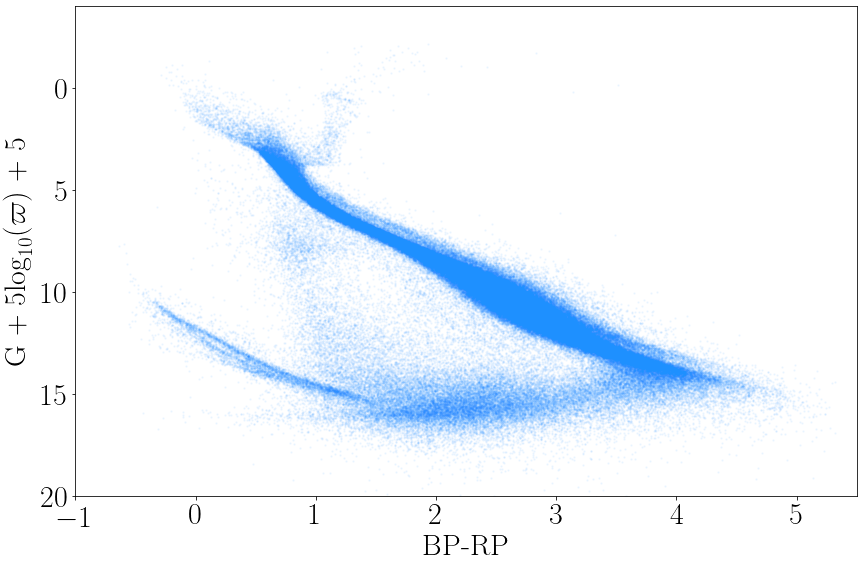

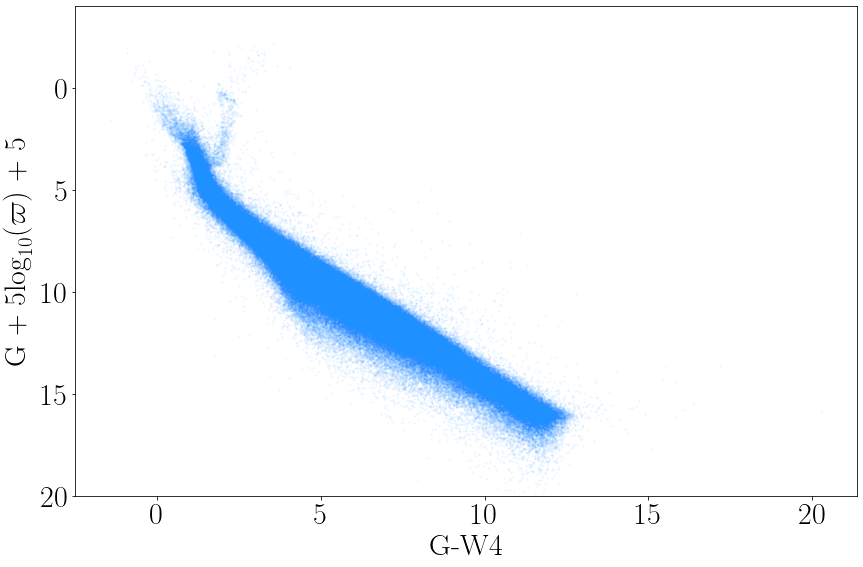

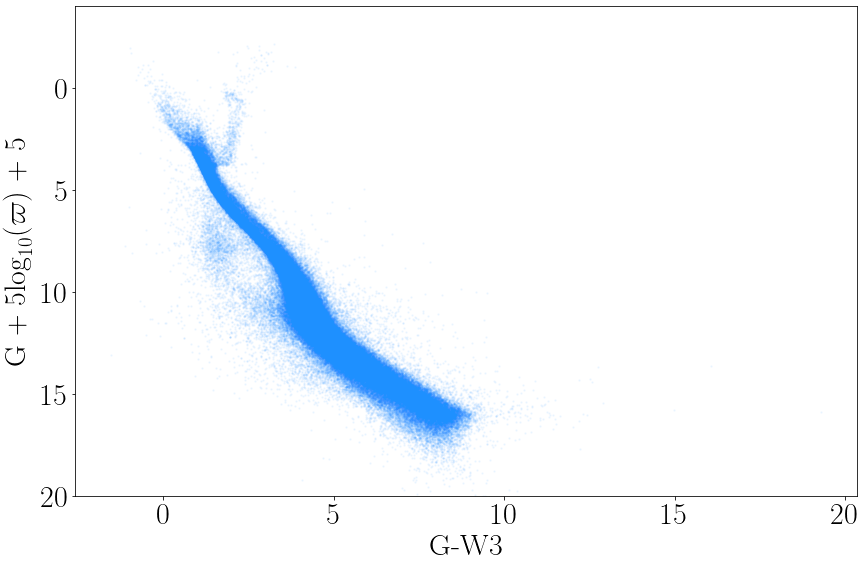

In [10]:
matplotlib.rcParams.update({'font.size': 30})

plt.figure(figsize=(14,9))
plt.scatter(df['bp_rp'],df['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-4)
plt.xlim(-1,5.5)
plt.show()
plt.close()

plt.figure(figsize=(14,9))
plt.scatter(df['g_w4'],df['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.xlabel('G-W4')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-4)
plt.show()
plt.close()

plt.figure(figsize=(14,9))
plt.scatter(df['g_w3'],df['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.xlabel('G-W3')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-4)
plt.show()
plt.close()

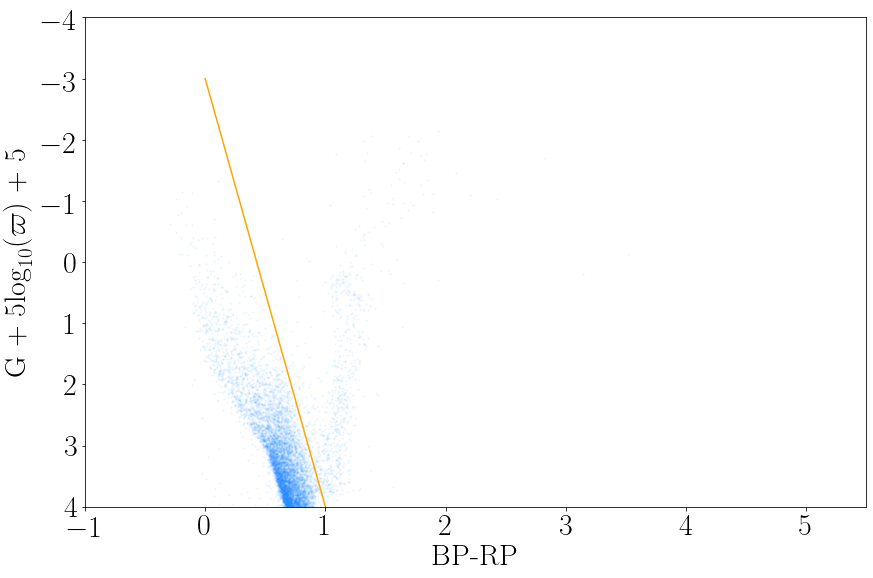

In [11]:
#Checking line to cut
x = np.linspace(0,2,10)
y = 7*x - 3.0

matplotlib.rcParams.update({'font.size': 30})

plt.figure(figsize=(14,9))
plt.plot(x,y,c='orange')
plt.scatter(df['bp_rp'],df['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(4,-4)
plt.xlim(-1,5.5)
plt.show()
plt.close()

In [0]:
#splitting data
#Massive star
df_mas = df[(df['g_abs'] < 4)]
#Not massive
df_sma = df[(df['g_abs'] >= 4)]

#Filtering for massive stars
df_mas = df_mas[(df_mas['g_abs'] > 7*df_mas['bp_rp'] - 3.0)]

#Reseting index
df_mas = df_mas.reset_index(drop=True)
df_sma = df_sma.reset_index(drop=True)

frames = [df_mas,df_sma]
df_new = pd.concat(frames)

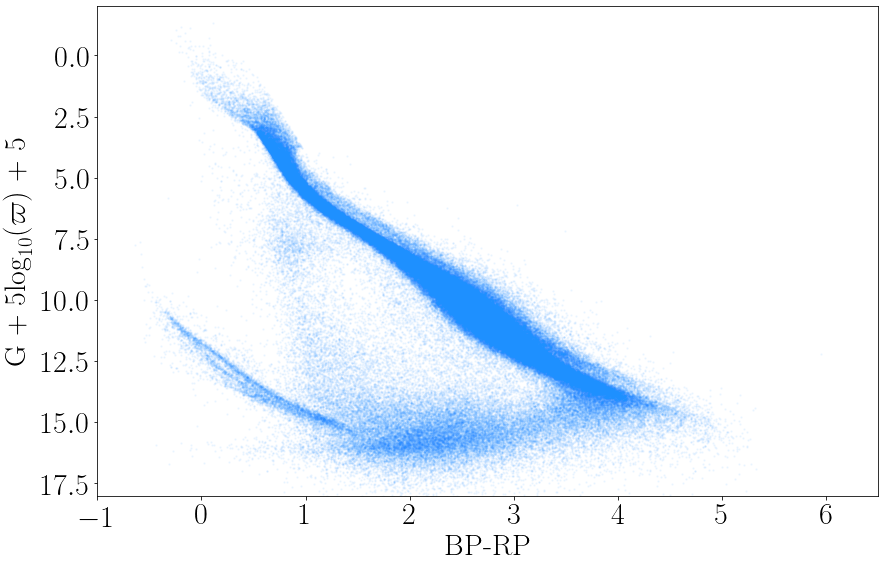

Cleaning RGB =  265452


In [13]:
#Cleaning RGS

#Massive star
df_mas = df[(df['g_abs'] < 4)]
#Not massive
df_sma = df[(df['g_abs'] >= 4)]

#Filtering for massive stars
df_mas = df_mas[(df_mas['g_abs'] > 7*df_mas['bp_rp'] - 3.0)]

#Reseting index
df_mas = df_mas.reset_index(drop=True)
df_sma = df_sma.reset_index(drop=True)

frames = [df_mas,df_sma]
df_new = pd.concat(frames)

x = np.linspace(0,2,10)
y = 7*x - 2.5

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_new['bp_rp'],df_new['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(18,-2)
plt.xlim(-1,6.5)
plt.show()
plt.close()
print('Cleaning RGB = ',len(df_new))

In [14]:
#Cleaning data with no errors in WISE
df_yes = df_new.dropna(subset=['w1mpro_error','w2mpro_error','w3mpro_error','w4mpro_error'])
print('Good S/N = ',len(df_yes))

df_1 = df_new[df_new['w1mpro_error'].isnull()]
df_2 = df_new[df_new['w2mpro_error'].isnull()]
df_3 = df_new[df_new['w3mpro_error'].isnull()]
df_4 = df_new[df_new['w4mpro_error'].isnull()]

df_1 = df_1.reset_index()
df_2 = df_2.reset_index()
df_3 = df_3.reset_index()
df_4 = df_4.reset_index()

df_no = [df_1,df_2,df_3,df_4]
df_no = pd.concat(df_no).drop_duplicates().reset_index(drop=True)
print('Bad S/N = ',len(df_no))
print(len(df_no)+len(df_yes))

Good S/N =  68545
Bad S/N =  196907
265452


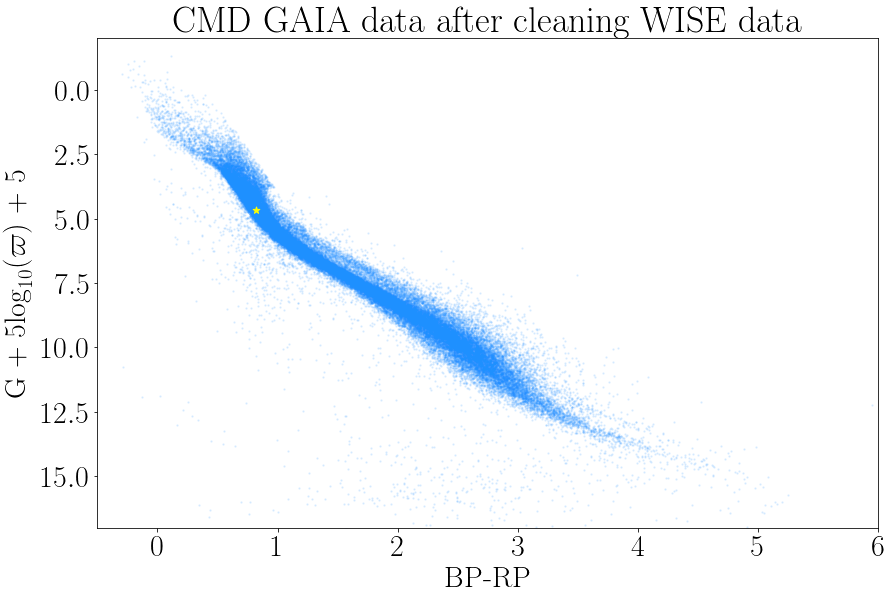

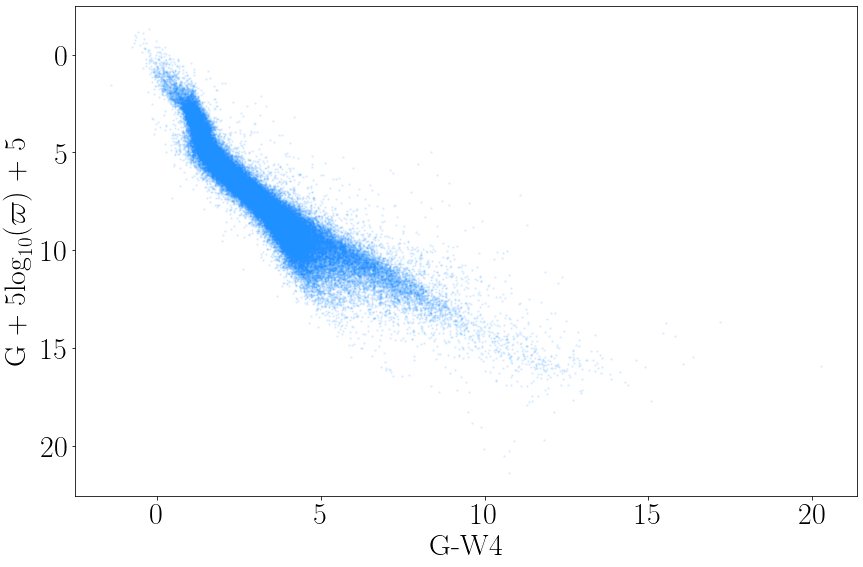

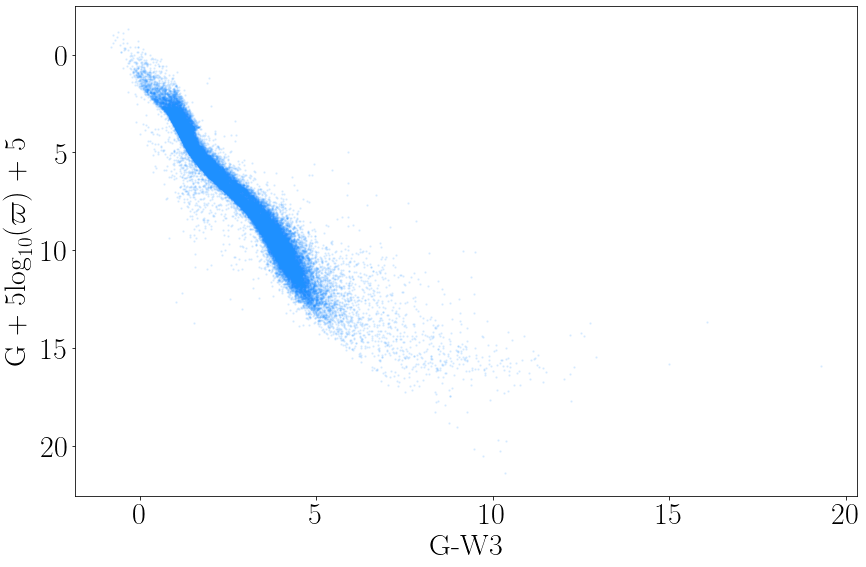

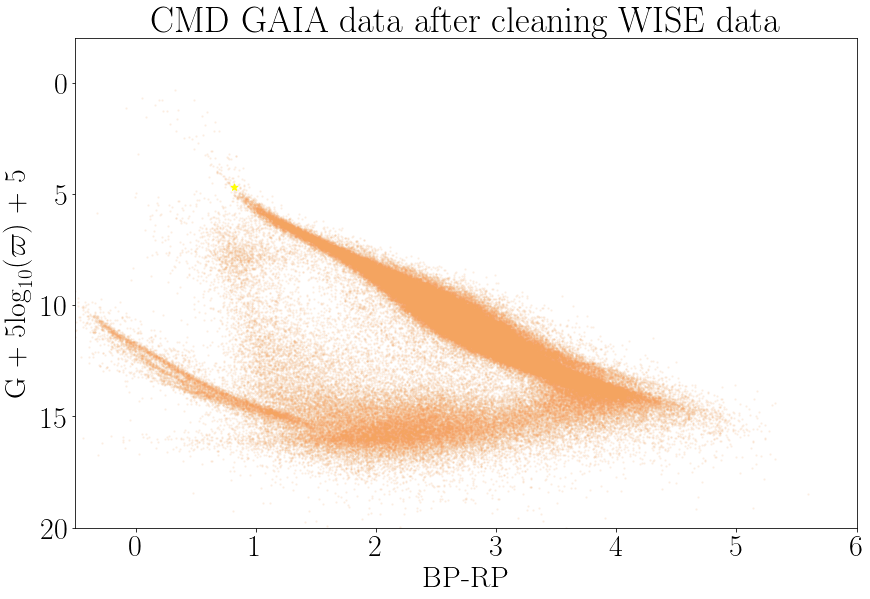

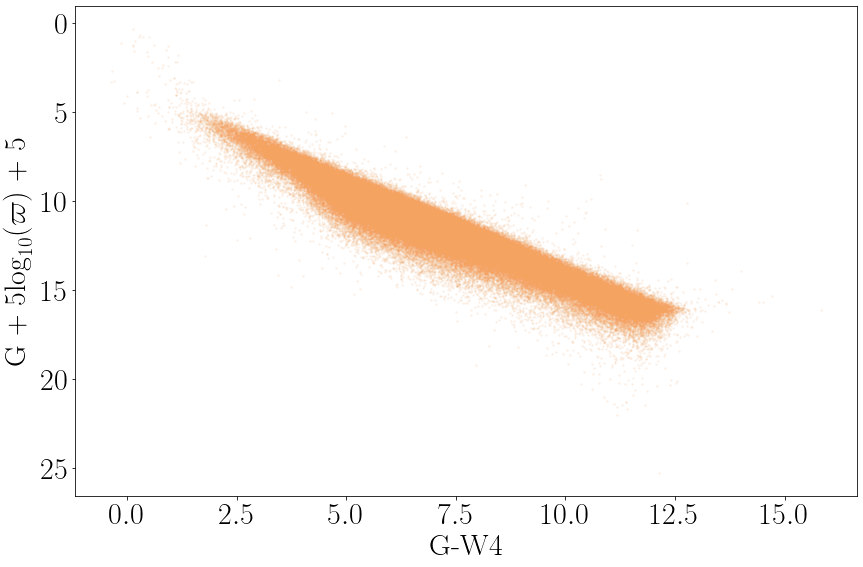

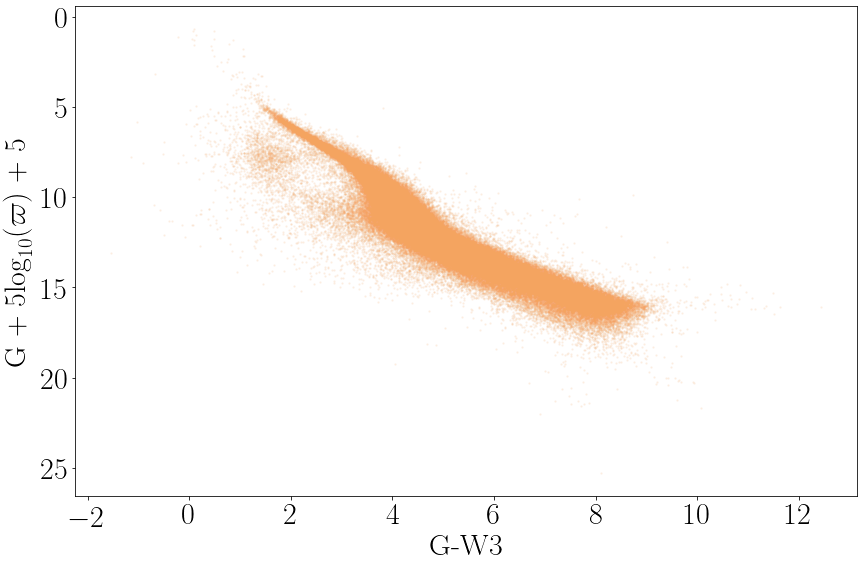

In [15]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))

plt.scatter(df_yes['bp_rp'],df_yes['g_abs'],alpha=0.1,c='dodgerblue',s=2)
plt.scatter([0.819],[4.68],c='yellow',s=50,marker='*')
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}(\varpi)$ + 5')
plt.gca().invert_yaxis()
plt.title('CMD GAIA data after cleaning WISE data')
#plt.axhline(4,c='dodgerblue')
plt.ylim(17,-2)
plt.xlim(-0.5,6)
plt.show()
plt.close()

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_yes['g_w4'],df_yes['g_abs'],alpha=0.1,c='dodgerblue',s=2)
plt.xlabel('G-W4')
plt.ylabel(r'G + 5$\log_{10}(\varpi)$ + 5')
plt.gca().invert_yaxis()
#plt.axhline(4,c='dodgerblue')
#plt.ylim(17,-2)
#plt.xlim(-0.5,6)
plt.show()
plt.close()

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_yes['g_w3'],df_yes['g_abs'],alpha=0.1,c='dodgerblue',s=2)
plt.xlabel('G-W3')
plt.ylabel(r'G + 5$\log_{10}(\varpi)$ + 5')
plt.gca().invert_yaxis()
#plt.axhline(4,c='dodgerblue')
#plt.ylim(17,-2)
#plt.xlim(-0.5,6)
plt.show()
plt.close()











matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_no['bp_rp'],df_no['g_abs'],alpha=0.1,c='sandybrown',s=2)
plt.scatter([0.819],[4.68],c='yellow',s=50,marker='*')
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}(\varpi)$ + 5')
plt.gca().invert_yaxis()
plt.title('CMD GAIA data after cleaning WISE data')
#plt.axhline(4,c='dodgerblue')
plt.ylim(20,-2)
plt.xlim(-0.5,6)
plt.show()
plt.close()

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_no['g_w4'],df_no['g_abs'],alpha=0.1,c='sandybrown',s=2)
plt.xlabel('G-W4')
plt.ylabel(r'G + 5$\log_{10}(\varpi)$ + 5')
plt.gca().invert_yaxis()
#plt.axhline(4,c='dodgerblue')
#plt.ylim(17,-2)
#plt.xlim(-0.5,6)
plt.show()
plt.close()

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_no['g_w3'],df_no['g_abs'],alpha=0.1,c='sandybrown',s=2)
plt.xlabel('G-W3')
plt.ylabel(r'G + 5$\log_{10}(\varpi)$ + 5')
plt.gca().invert_yaxis()
#plt.axhline(4,c='dodgerblue')
#plt.ylim(17,-2)
#plt.xlim(-0.5,6)
plt.show()
plt.close()

All yes stars with luminosities =  45004
All no stars with luminosities =  11994
Good S/N with no luminosities =  68545
Bad S/N with no luminosities =  184913
253458


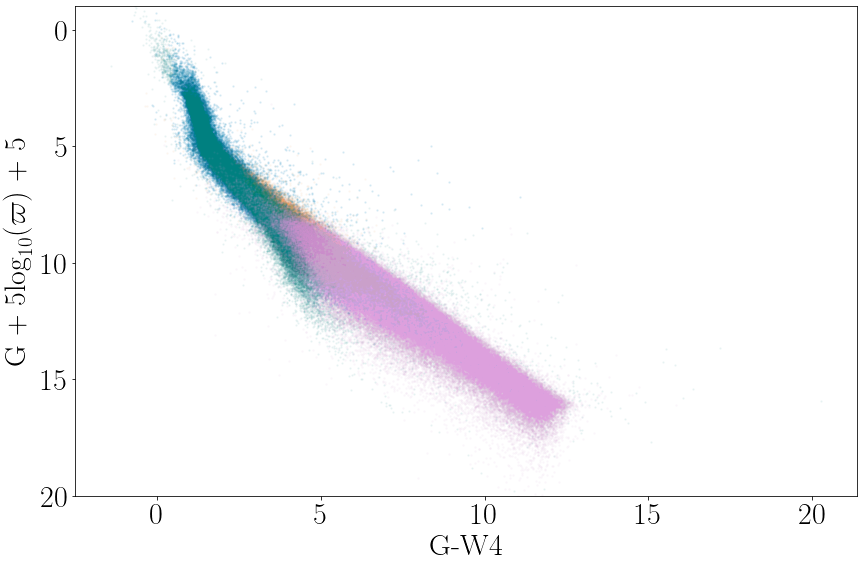

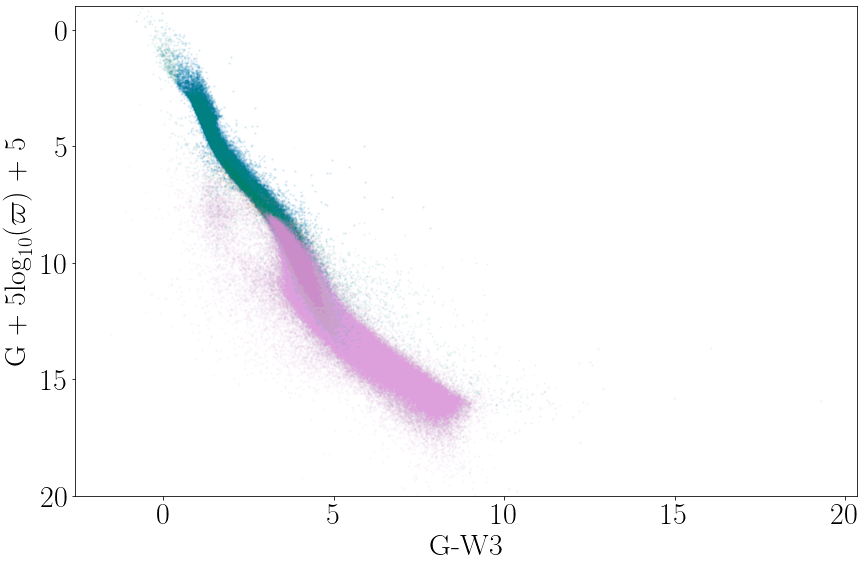

Highest magnitude =  9.714195569399415 9.711772129283933


In [27]:
df_lum_yes = df_yes.dropna(subset=['lum_val'])
df_lum_yes = df_lum_yes.reset_index(drop=True)
print('All yes stars with luminosities = ',len(df_lum_yes))

df_lum_no = df_no.dropna(subset=['lum_val'])
df_lum_no = df_lum_no.reset_index(drop=True)
print('All no stars with luminosities = ',len(df_lum_no))


#Cleaning data with no errors in WISE
df_nolum = df_new[df_new['lum_val'].isnull()]
df_nolum = df_nolum.reset_index()

#Cleaning data with no errors in WISE
df_nolum_yes = df_new.dropna(subset=['w1mpro_error','w2mpro_error','w3mpro_error','w4mpro_error'])
print('Good S/N with no luminosities = ',len(df_yes))

df_1 = df_nolum[df_nolum['w1mpro_error'].isnull()]
df_2 = df_nolum[df_nolum['w2mpro_error'].isnull()]
df_3 = df_nolum[df_nolum['w3mpro_error'].isnull()]
df_4 = df_nolum[df_nolum['w4mpro_error'].isnull()]

df_1 = df_1.reset_index()
df_2 = df_2.reset_index()
df_3 = df_3.reset_index()
df_4 = df_4.reset_index()

df_nolum_no = [df_1,df_2,df_3,df_4]
df_nolum_no = pd.concat(df_nolum_no).drop_duplicates().reset_index(drop=True)
print('Bad S/N with no luminosities = ',len(df_nolum_no))
print(len(df_nolum_no)+len(df_nolum_yes))







matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
#m = 3
#n = 2.5
#dx = -3
#x0 = np.linspace(-2.5,7,3)
#y0 = linea_m(x0,m,n)
#y1 = linea_m(x0+dx,m,n-m*dx)
#plt.plot(x0,y0,c='orange')
#plt.plot(x0-dx,y1,c='orange')
#plt.axhline(y0[0],0.045,0.195,c='orange')
#plt.axhline(y0[-1],0.52,0.67,c='orange')
plt.scatter(df_lum_yes['g_w4'],df_lum_yes['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.scatter(df_lum_no['g_w4'],df_lum_no['g_abs'],alpha=0.05,c='sandybrown',s=2)
plt.scatter(df_nolum_yes['g_w4'],df_nolum_yes['g_abs'],alpha=0.05,c='teal',s=2)
plt.scatter(df_nolum_no['g_w4'],df_nolum_no['g_abs'],alpha=0.05,c='plum',s=2)
plt.xlabel('G-W4')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-1)
plt.show()
plt.close()

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
#m = 1
#n = 2.5
#dx = -3
#x0 = np.linspace(-2.5,7,3)
#y0 = linea_m(x0,m,n)
#y1 = linea_m(x0+dx,m,n-m*dx)
#plt.plot(x0,y0,c='orange')
#plt.plot(x0-dx,y1,c='orange')
#plt.axhline(y0[0],0.045,0.195,c='orange')
#plt.axhline(y0[-1],0.52,0.67,c='orange')
plt.scatter(df_lum_yes['g_w3'],df_lum_yes['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.scatter(df_lum_no['g_w3'],df_lum_no['g_abs'],alpha=0.05,c='sandybrown',s=2)
plt.scatter(df_nolum_yes['g_w3'],df_nolum_yes['g_abs'],alpha=0.05,c='teal',s=2)
plt.scatter(df_nolum_no['g_w3'],df_nolum_no['g_abs'],alpha=0.05,c='plum',s=2)
plt.xlabel('G-W3')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-1)
plt.show()
plt.close()



print('Highest magnitude = ',np.max(df_lum_yes['g_abs']),np.max(df_lum_no['g_abs']))
g_max = np.max( [np.max(df_lum_yes['g_abs']),np.max(df_lum_no['g_abs'])]   )

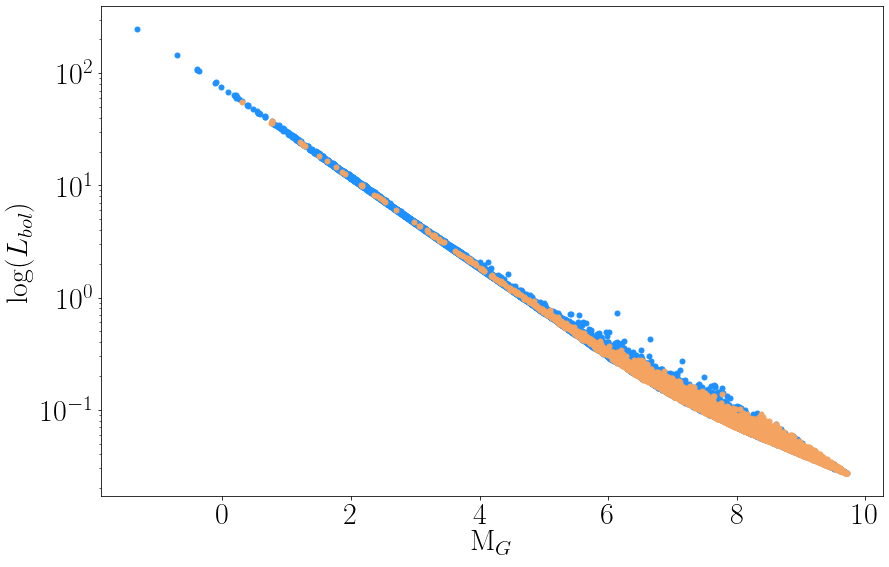

In [39]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_lum_yes['g_abs'],df_lum_yes['lum_val'],alpha=1,c='dodgerblue',s=25)
plt.scatter(df_lum_no['g_abs'],df_lum_no['lum_val'],alpha=1,c='sandybrown',s=25)
plt.xlabel('M$_{G}$')
plt.ylabel(r'$\log (L_{bol})$')
plt.yscale('log')
plt.show()
plt.close()

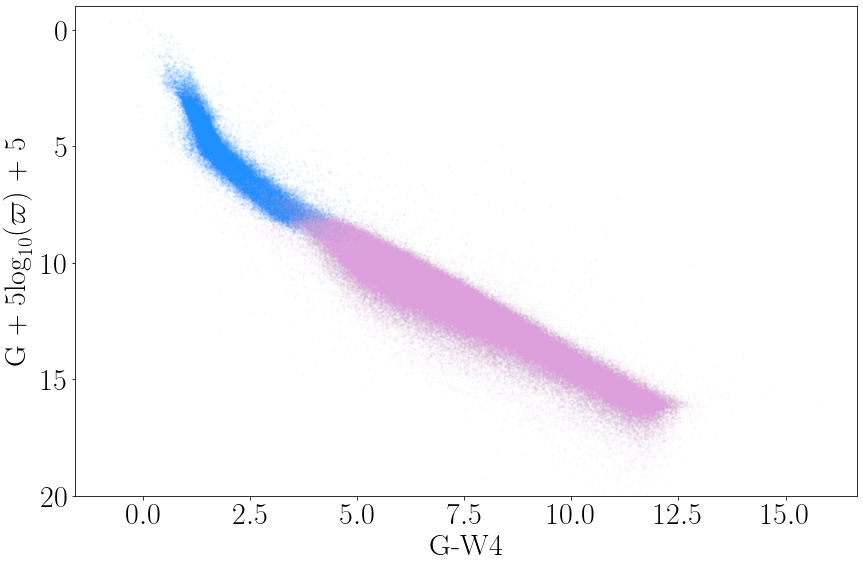

In [48]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_lum_yes['g_w4'],df_lum_yes['g_abs'],alpha=0.05,c='dodgerblue',s=2)
#plt.scatter(df_lum_no['g_w4'],df_lum_no['g_abs'],alpha=0.05,c='sandybrown',s=2)
#plt.scatter(df_nolum_yes['g_w4'],df_nolum_yes['g_abs'],alpha=0.05,c='teal',s=2)
plt.scatter(df_nolum_no['g_w4'],df_nolum_no['g_abs'],alpha=0.05,c='plum',s=2)
plt.xlabel('G-W4')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-1)
plt.show()
plt.close()

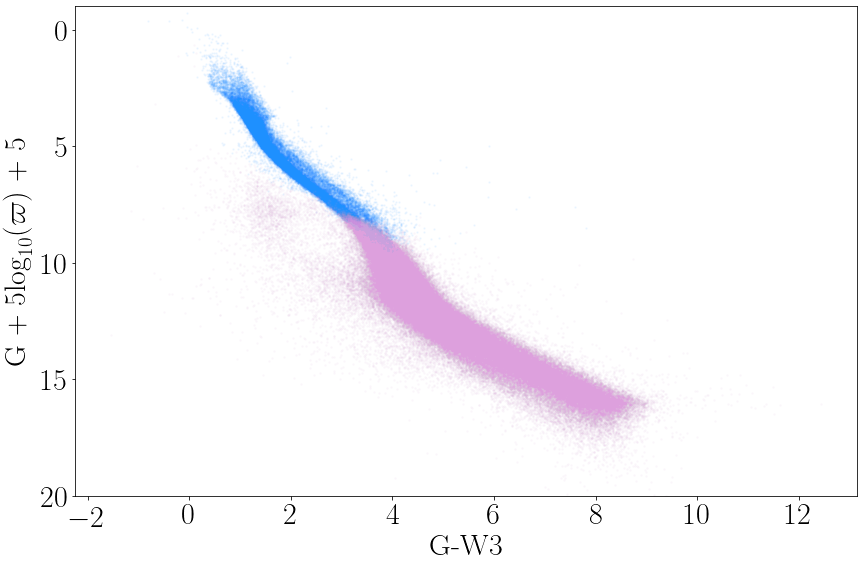

In [47]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_lum_yes['g_w3'],df_lum_yes['g_abs'],alpha=0.05,c='dodgerblue',s=2)
#plt.scatter(df_lum_no['g_w3'],df_lum_no['g_abs'],alpha=0.05,c='sandybrown',s=2)
#plt.scatter(df_nolum_yes['g_w3'],df_nolum_yes['g_abs'],alpha=0.05,c='teal',s=2)
plt.scatter(df_nolum_no['g_w3'],df_nolum_no['g_abs'],alpha=0.05,c='plum',s=2)
plt.xlabel('G-W3')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-1)
plt.show()
plt.close()

In [0]:
df_nolum_no['lum_val'] = 10**(0.0017346805261994605*df_nolum_no['g_abs']**2 - 0.3500366408418993*df_nolum_no['g_abs'] + 1.5501893039475332)

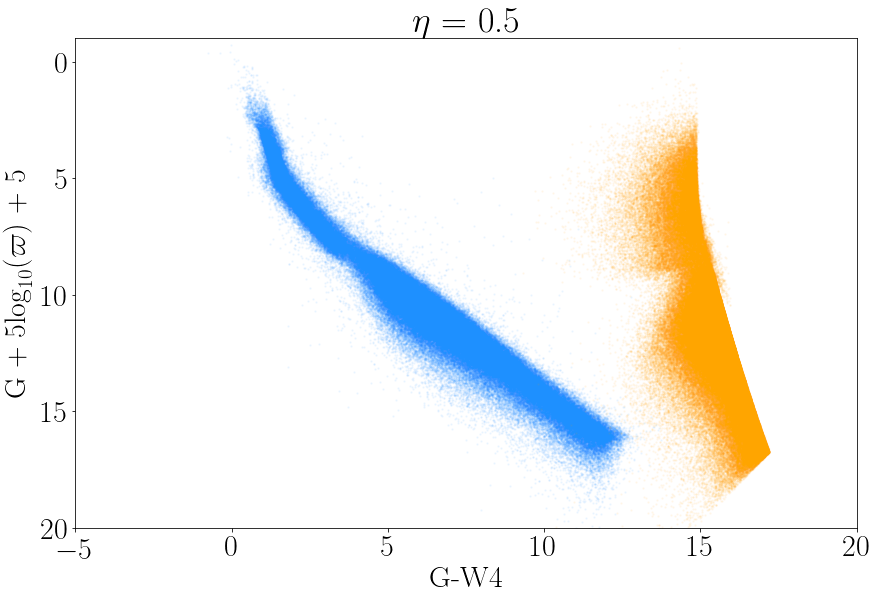

In [59]:
tt = 100
ee = 5e-1



frames = [df_lum_yes,df_nolum_no]
df_center= pd.concat(frames)

gdstop = G_DS(np.array(df_center['phot_g_mean_mag']),tt,np.array(df_center['lum_val']),ee)
w4dstop = W4_DS(np.array(df_center['w4mpro']),tt,np.array(df_center['lum_val']),ee)
Gdstop = G_DS(np.array(df_center['g_abs']),tt,np.array(df_center['lum_val']),ee)

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_center['g_w4'],df_center['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.scatter(gdstop-w4dstop,Gdstop,alpha=0.05,c='orange',s=2)
plt.xlabel('G-W4')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-1)
plt.xlim(-5,20)
plt.title(r'$\eta$ = '+str(ee))

plt.show()
plt.close()